In [80]:
import numpy as np
import pandas as pd
import time
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from scipy.interpolate import interp1d

In [2]:
from Generators.GA.TestGeneticAlgorithm import GeneticAlgorithm
from Generators.Optimizers.GradientDescent import GradientDescent
from Generators.Optimizers.GuidedLocalSearch import GuidedLocalSearch
from Generators.Optimizers.HillClimbAlgorithm import HillClimbAlgorithm
from Generators.Optimizers.MicrocanonicalAnnealing import MicrocanonicalAnnealing
from Generators.Optimizers.ParticleSwarm import ParticleSwarm
from Generators.Optimizers.SimulatedAnnealing import SimulatedAnnealing
from Generators.Optimizers.TabuSearch import TabuSearch
from Generators.Optimizers.AdaptiveTabuSearch import AdaptiveTabuSearch

kwargs = {
    'cnn_model_path': 'Models/CNN_6_1_2.keras',
    'masked_sequence': 'AATACTAGAGGTCTTCCGACNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGTGTGGGCGGGAAGACAACTAGGGG',
    'early_stopping_patience': 100,
}
target_expressions = [0, 0.25, 0.5, 0.75, 1]

iterations = 5

optimizers = {
    'Genetic Algorithm': GeneticAlgorithm,
    'Gradient Descent': GradientDescent,
    'Guided Local Search': GuidedLocalSearch,
    'Hill Climb Algorithm': HillClimbAlgorithm,
    'Microcanonical Annealing': MicrocanonicalAnnealing,
    'Particle Swarm': ParticleSwarm,
    'Simulated Annealing': SimulatedAnnealing,
    'Tabu Search': TabuSearch,
    'Adaptive Tabu Search': AdaptiveTabuSearch,
}

### Testing Each Optimizer
---

In [3]:
results = {
    'optimizer': [],
    'target_expression': [],
    'iteration': [],
    'sequence': [],
    'prediction': [],
    'error': [],
    'runtime': [],
    'prediction_history': [],
    'error_history': [],
}

for optimizer_name, optimizer_class in optimizers.items():
    for target_expression in target_expressions:
        for i in range(1, iterations+1):
            
            # if optimizer is deterministic, only run once
            if optimizer_name in ['Hill Climb Algorithm', 'Tabu Search', 'Adaptive Tabu Search'] and i > 1:
                continue

            print(f'{optimizer_name} | target_expression = {target_expression} | Iteration {i}', end='\r')
        
            convergence = []
            
            obj = optimizer_class(
                **kwargs,
                target_expression=target_expression,
                seed=i,
            )
            start_time = time.time()
            best_sequence, best_prediction, best_error = obj.run()
            end_time = time.time()
            prediction_history = obj.prediction_history

            prediction_history = np.array(prediction_history).flatten()
            error_history = np.array([abs(target_expression - pred) for pred in prediction_history])

            results['optimizer'].append(optimizer_name)
            results['target_expression'].append(target_expression)
            results['iteration'].append(i)
            results['sequence'].append(best_sequence)
            results['prediction'].append(best_prediction)
            results['error'].append(best_error)
            results['runtime'].append(end_time - start_time)
            results['prediction_history'].append(list(prediction_history))
            results['error_history'].append(list(error_history))

            print(' ' * 100, end='\r')
    print(f'{optimizer_name} Complete')

print('Evaluation Complete')

results_df = pd.DataFrame(results)
results_df.to_csv('Data/optimizer_evaluation_results.csv', index=False)
results_df.head()

Genetic Algorithm Complete                                                                          
Gradient Descent Complete                                                                           
Guided Local Search Complete                                                                        
Hill Climb Algorithm Complete                                                                       
Microcanonical Annealing Complete                                                                   
Particle Swarm Complete                                                                             
Simulated Annealing Complete                                                                        
Tabu Search Complete                                                                                
Adaptive Tabu Search Complete                                                                       
Evaluation Complete


,optimizer,target_expression,iteration,sequence,prediction,error,runtime,prediction_history,error_history
0,Genetic Algorithm,0.0,1,AATACTAGAGGTCTTCCGACCTATTGTTGCCCCCCTTCACTTTGTT...,0.125271,0.125271,13.813914,"[0.19003505, 0.1742371, 0.1742371, 0.1742371, ...","[0.19003504514694214, 0.17423710227012634, 0.1..."
1,Genetic Algorithm,0.0,2,AATACTAGAGGTCTTCCGACCCTAGCCTTTTGCATCCAACCGCACG...,0.128758,0.128758,14.052443,"[0.21155733, 0.20428011, 0.20349696, 0.1908876...","[0.2115573287010193, 0.20428010821342468, 0.20..."
2,Genetic Algorithm,0.0,3,AATACTAGAGGTCTTCCGACGCATTCGTTATTGGCACCCCACGCTT...,0.107874,0.107874,17.090239,"[0.20979398, 0.18558095, 0.18558095, 0.1823005...","[0.20979398488998413, 0.18558095395565033, 0.1..."
3,Genetic Algorithm,0.0,4,AATACTAGAGGTCTTCCGACCTCTTGCATTGCCCCCGCTCCTAATG...,0.136499,0.136499,14.576311,"[0.19595844, 0.19370854, 0.190929, 0.18500704,...","[0.1959584355354309, 0.19370853900909424, 0.19..."
4,Genetic Algorithm,0.0,5,AATACTAGAGGTCTTCCGACCCTAATTCGGCTTGTCGCCCCCGCTC...,0.134320,0.134320,13.477380,"[0.21676664, 0.19829234, 0.19033377, 0.1816486...","[0.21676664054393768, 0.1982923448085785, 0.19..."


In [57]:
# Average each optimizer's results across iterations
def average_tests(df):
    def average_lists(series_of_lists):
        return np.mean(list(zip(*series_of_lists)), axis=1).tolist()

    grouped = df.groupby(['optimizer', 'target_expression'])

    return grouped.agg({
        'prediction': 'mean',
        'error': 'mean',
        'runtime': 'mean',
        'prediction_history': average_lists,
        'error_history': average_lists
    }).reset_index()

# Get the best test for each optimizer and target expression
def best_tests(df):
    grouped = df.groupby(['optimizer', 'target_expression'])
    best_rows = []
    for (optimizer, target), group in grouped:
        best_error_idx = group['error'].idxmin()
        best_row = group.loc[best_error_idx]

        best_rows.append({
            'optimizer': optimizer,
            'target_expression': target,
            'sequence': best_row['sequence'],
            'prediction': best_row['prediction'],
            'error': best_row['error'],
            'runtime': best_row['runtime'],
            'prediction_history': best_row['prediction_history'],
            'error_history': best_row['error_history'],
        })
    return pd.DataFrame(best_rows)

# returns a list of predictions that are the best seen so far for each iteration
def calculate_best_prediction_history(prediction_history, target_expression):
    best_prediction = prediction_history[0]
    best_prediction_history = [best_prediction]

    for i in range(1, len(prediction_history)):
        current_prediction = prediction_history[i]
        if abs(current_prediction - target_expression) < abs(best_prediction - target_expression):
            best_prediction = current_prediction
        best_prediction_history.append(best_prediction)
    
    return best_prediction_history


def dynamic_standardize_prediction_history(df):
    df['prediction_rate'] = df.apply(lambda row: len(row['prediction_history']) / row['runtime'], axis=1)
    max_rate = df['prediction_rate'].max()

    def resample_predictions(predictions, runtime, max_rate):
        num_points = int(max_rate * runtime)
        if num_points < 2:
            return [predictions[0]] * 2
        
        original_time = np.linspace(0, runtime, len(predictions))
        standardized_time = np.linspace(0, runtime, num_points)
        interpolated_predictions = np.interp(standardized_time, original_time, predictions)
        return interpolated_predictions.tolist()

    df['prediction_history'] = df.apply(
        lambda row: resample_predictions(row['prediction_history'], row['runtime'], max_rate),
        axis=1
    )
    # df.drop(columns=['prediction_rate'], inplace=True)
    return df

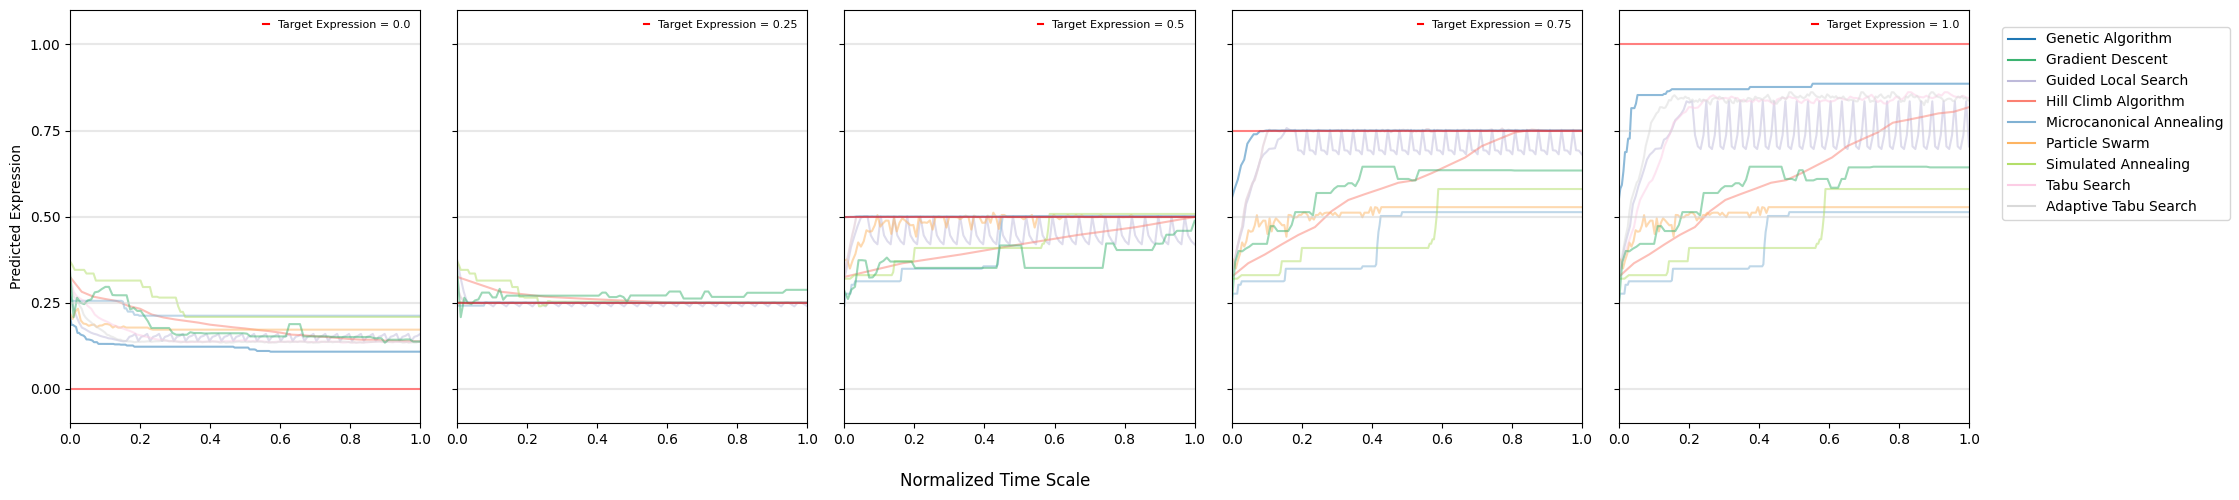

In [5]:
import ast

# -------------- Loading The Results --------------

results_df = pd.read_csv('Data/optimizer_evaluation_results.csv')
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

# get the best test for each optimizer and target expression
results_df = best_tests(results_df)

# -------------- Get The Best Test For Each Optimizer And Target Expression --------------

df_exploded = results_df.explode('prediction_history').reset_index(drop=True)
df_exploded['prediction_history'] = df_exploded['prediction_history'].astype(float)

df_exploded['iteration'] = df_exploded.groupby(['optimizer', 'target_expression']).cumcount()
group_sizes = df_exploded.groupby(['optimizer', 'target_expression'])['prediction_history'].transform('count')
df_exploded['normalized_time_scale'] = df_exploded['iteration'] / (group_sizes - 1)

# ---------- Define The Optimizer Colors, Order, and Target Expressions ----------

optimizer_names = optimizers.keys()

bold_optimizers = {
    'Genetic Algorithm': 'tab:blue',
    'Gradient Descent': 'mediumseagreen'
}
muted_optimizers = {name: plt.cm.Set3(i) for i, name in enumerate(optimizer_names) if name not in bold_optimizers}
color_map = {**bold_optimizers, **muted_optimizers}

optimizer_plot_order = list(muted_optimizers.keys()) + list(bold_optimizers.keys())

target_expressions = df_exploded['target_expression'].unique()

# -------------- Plot The Errors Over Time --------------

fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)
axes = axes.flatten()

for ax, target_expr in zip(axes, target_expressions):
    # plot the muted optimizers, then the bold optimizers (using optimizer_plot_order)
    for optimizer in optimizer_plot_order:
        group = df_exploded[
            (df_exploded['target_expression'] == target_expr) &
            (df_exploded['optimizer'] == optimizer)
        ]
        if not group.empty:
            ax.plot(
                group['normalized_time_scale'],
                group['prediction_history'],
                color=color_map[optimizer],
                alpha=0.5,
                label=optimizer
            )

    # plot target expression lines
    for each in target_expressions:
        color = 'lightgrey' if each != target_expr else 'red'
        ax.axhline(y=each, color=color, linestyle='-', alpha=0.5)

    # add a legend, but only for the target_expressions line
    labels = [f'Target Expression = {each}' for each in target_expressions if each == target_expr]
    handles = [plt.Line2D([], [], color='red', label=f'Target Expression = {target_expr}')]
    ax.legend(handles=handles, loc='upper right', fontsize=8, frameon=False, handlelength=0.5, handleheight=0.5, labelspacing=0.5)

    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(0, 1)
    # ax.set_title(f'Target: {target_expr}')

axes[0].set_yticks(np.arange(0, 1.1, 0.25))
axes[0].set_ylabel('Predicted Expression')
fig.supxlabel("Normalized Time Scale")

# add the optimizer legend
labels = [opt for opt in optimizer_names]
handles = [plt.Line2D([], [], color=color_map[opt], label=opt) for opt in optimizer_names]
fig.legend(
    handles=handles,
    labels=labels,
    loc='upper left',
    bbox_to_anchor=(1, 0.95),
    bbox_transform=fig.transFigure
)

plt.tight_layout()
plt.show()


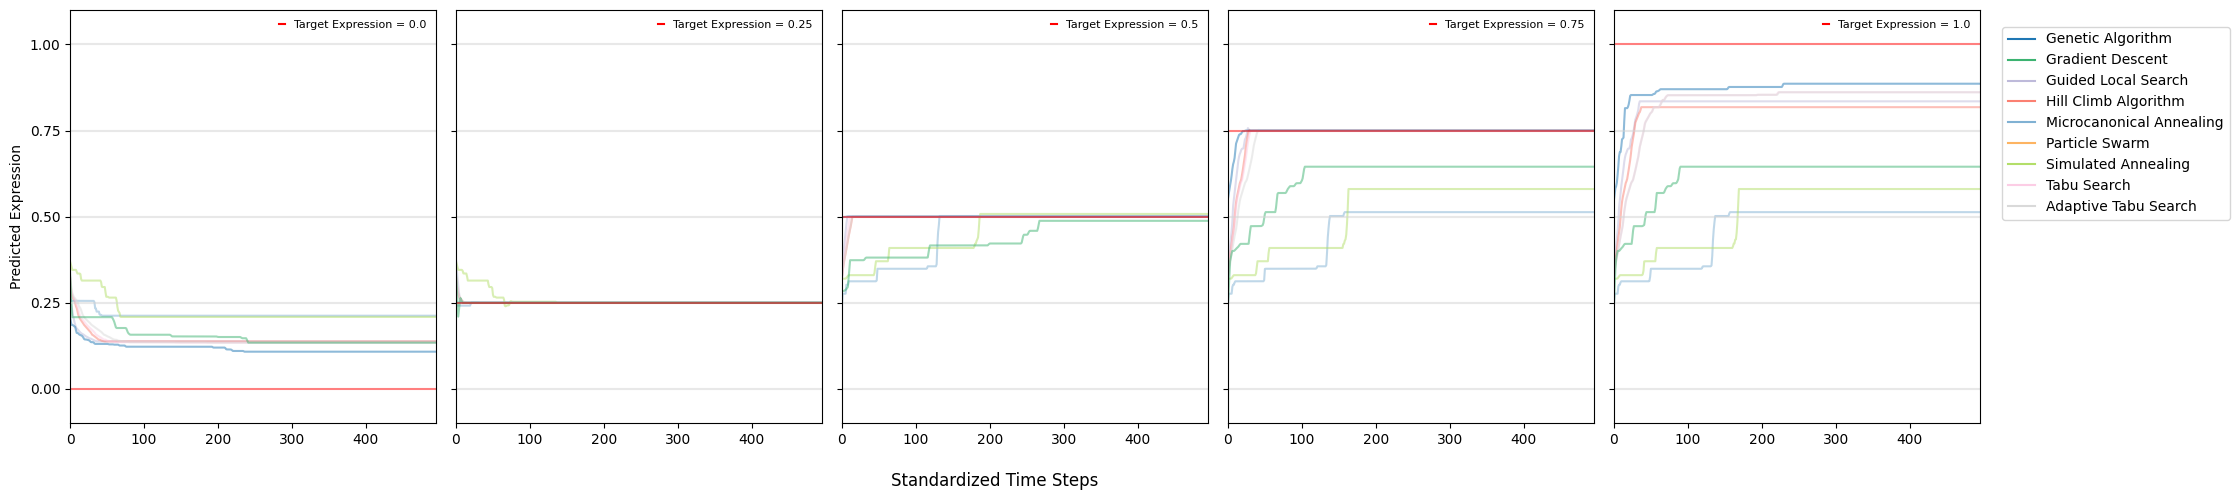

In [6]:
import ast

# -------------- Loading The Results --------------

results_df = pd.read_csv('Data/optimizer_evaluation_results.csv')
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

# exclude particle swarm
results_df = results_df[results_df['optimizer'] != 'Particle Swarm']

# get the best test for each optimizer and target expression
results_df = best_tests(results_df)

results_df['prediction_history'] = results_df.apply(
    lambda row: calculate_best_prediction_history(row['prediction_history'], row['target_expression']), axis=1
)

results_df = dynamic_standardize_prediction_history(results_df)


# stretch the lengths of each prediction_history to the maximum length
max_length = results_df['prediction_history'].apply(len).max()

results_df['prediction_history'] = results_df['prediction_history'].apply(
    lambda preds: preds + [preds[-1]] * (max_length - len(preds))
)

# ---------- Define The Optimizer Colors, Order, and Target Expressions ----------

optimizer_names = optimizers.keys()

bold_optimizers = {
    'Genetic Algorithm': 'tab:blue',
    'Gradient Descent': 'mediumseagreen'
}
muted_optimizers = {name: plt.cm.Set3(i) for i, name in enumerate(optimizer_names) if name not in bold_optimizers}
color_map = {**bold_optimizers, **muted_optimizers}

optimizer_plot_order = list(muted_optimizers.keys()) + list(bold_optimizers.keys())

target_expressions = results_df['target_expression'].unique()

# -------------- Plot The Errors Over Time --------------

fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)
axes = axes.flatten()

for ax, target_expr in zip(axes, target_expressions):
    # plot the muted optimizers, then the bold optimizers (using optimizer_plot_order)
    for optimizer in optimizer_plot_order:
        group = results_df[
            (results_df['target_expression'] == target_expr) &
            (results_df['optimizer'] == optimizer)
        ]
        if not group.empty:
            for idx, row in group.iterrows():
                ax.plot(
                    list(range(len(row['prediction_history']))),
                    row['prediction_history'],
                    color=color_map[optimizer],
                    alpha=0.5,
                    label=optimizer
                )


    # plot target expression lines
    for each in target_expressions:
        color = 'lightgrey' if each != target_expr else 'red'
        ax.axhline(y=each, color=color, linestyle='-', alpha=0.5)

    # add a legend, but only for the target_expressions line
    labels = [f'Target Expression = {each}' for each in target_expressions if each == target_expr]
    handles = [plt.Line2D([], [], color='red', label=f'Target Expression = {target_expr}')]
    ax.legend(handles=handles, loc='upper right', fontsize=8, frameon=False, handlelength=0.5, handleheight=0.5, labelspacing=0.5)

    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(0, max_length)

axes[0].set_yticks(np.arange(0, 1.1, 0.25))
axes[0].set_ylabel('Predicted Expression')
fig.supxlabel("Standardized Time Steps")

# add the optimizer legend
labels = [opt for opt in optimizer_names]
handles = [plt.Line2D([], [], color=color_map[opt], label=opt) for opt in optimizer_names]
fig.legend(
    handles=handles,
    labels=labels,
    loc='upper left',
    bbox_to_anchor=(1, 0.95),
    bbox_transform=fig.transFigure
)

plt.tight_layout()
plt.show()


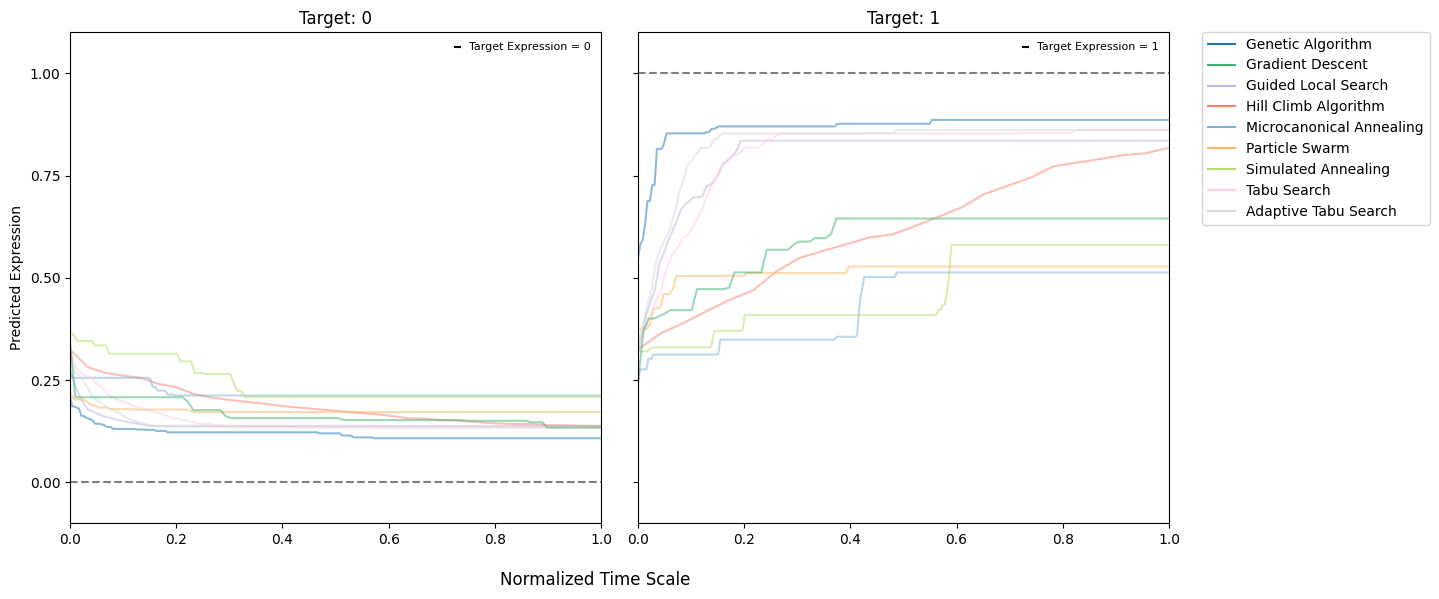

In [7]:
# -------------- Loading The Results --------------

results_df = pd.read_csv('Data/optimizer_evaluation_results.csv')
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

# get the best test for each optimizer and target expression
results_df = best_tests(results_df)

results_df['prediction_history'] = results_df.apply(
    lambda row: calculate_best_prediction_history(row['prediction_history'], row['target_expression']), axis=1
)

# -------------- Get The Best Test For Each Optimizer And Target Expression --------------

df_exploded = results_df.explode('prediction_history').reset_index(drop=True)
df_exploded['prediction_history'] = df_exploded['prediction_history'].astype(float)

df_exploded['iteration'] = df_exploded.groupby(['optimizer', 'target_expression']).cumcount()
group_sizes = df_exploded.groupby(['optimizer', 'target_expression'])['prediction_history'].transform('count')
df_exploded['normalized_time_scale'] = df_exploded['iteration'] / (group_sizes - 1)

# ---------- Define The Optimizer Colors, Order, and Target Expressions ----------

optimizer_names = optimizers.keys()

bold_optimizers = {
    'Genetic Algorithm': 'tab:blue',
    'Gradient Descent': 'mediumseagreen'
}
muted_optimizers = {name: plt.cm.Set3(i) for i, name in enumerate(optimizer_names) if name not in bold_optimizers}
color_map = {**bold_optimizers, **muted_optimizers}

optimizer_plot_order = list(muted_optimizers.keys()) + list(bold_optimizers.keys())

target_expressions = [0, 1]

# -------------- Plot The Errors Over Time --------------

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
axes = axes.flatten()

for ax, target_expr in zip(axes, target_expressions):
    # plot the muted optimizers, then the bold optimizers (using optimizer_plot_order)
    for optimizer in optimizer_plot_order:
        group = df_exploded[
            (df_exploded['target_expression'] == target_expr) &
            (df_exploded['optimizer'] == optimizer)
        ]
        if not group.empty:
            ax.plot(
                group['normalized_time_scale'],
                group['prediction_history'],
                color=color_map[optimizer],
                alpha=0.5,
                label=optimizer
            )

    # plot target expression lines
    ax.axhline(y=target_expr, color='black', linestyle='--', alpha=0.5)

    # add a legend, but only for the target_expressions line
    labels = [f'Target Expression = {each}' for each in target_expressions if each == target_expr]
    handles = [plt.Line2D([], [], color='black', label=f'Target Expression = {target_expr}')]
    ax.legend(handles=handles, loc='upper right', fontsize=8, frameon=False, handlelength=0.5, handleheight=0.5, labelspacing=0.5)

    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(0, 1)
    ax.set_title(f'Target: {target_expr}')

axes[0].set_yticks(np.arange(0, 1.1, 0.25))
axes[0].set_ylabel('Predicted Expression')
fig.supxlabel("Normalized Time Scale")

# add the optimizer legend
labels = [opt for opt in optimizer_names]
handles = [plt.Line2D([], [], color=color_map[opt], label=opt) for opt in optimizer_names]
fig.legend(
    handles=handles,
    labels=labels,
    loc='upper left',
    bbox_to_anchor=(1, 0.95),
    bbox_transform=fig.transFigure
)

plt.tight_layout()
plt.show()


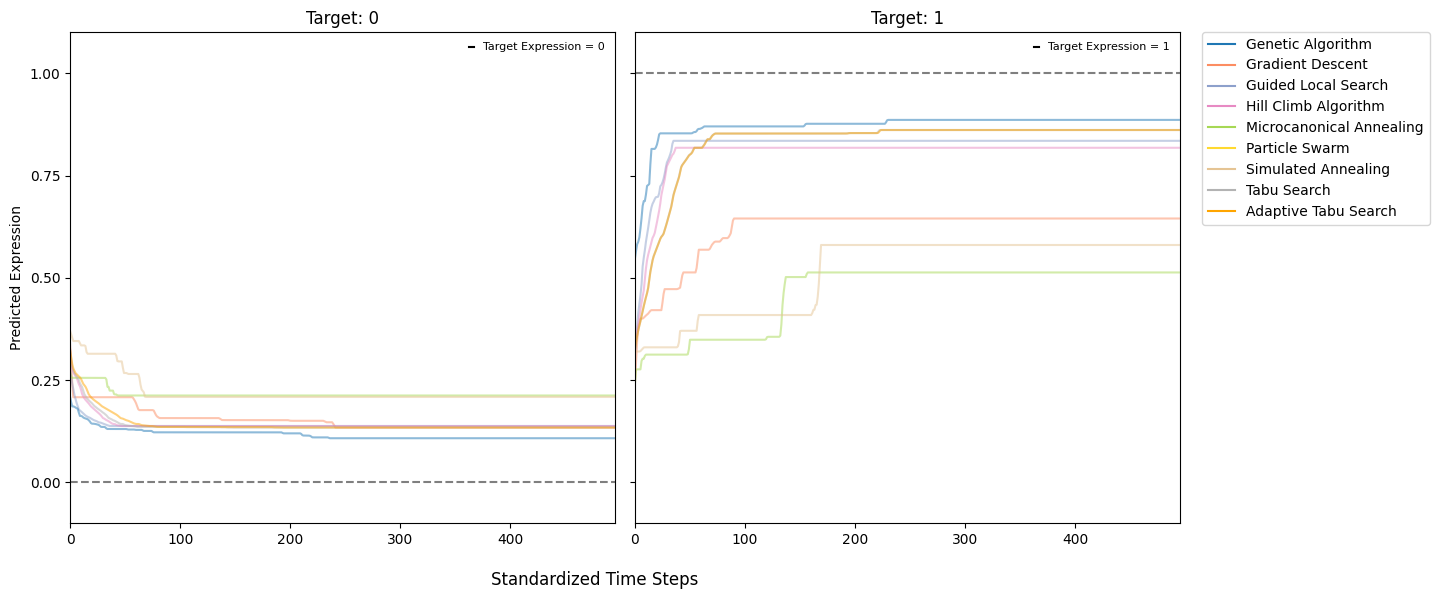

In [8]:
# -------------- Loading The Results --------------

results_df = pd.read_csv('Data/optimizer_evaluation_results.csv')
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

# exclude particle swarm
results_df = results_df[results_df['optimizer'] != 'Particle Swarm']

# get the best test for each optimizer and target expression
results_df = best_tests(results_df)

results_df['prediction_history'] = results_df.apply(
    lambda row: calculate_best_prediction_history(row['prediction_history'], row['target_expression']), axis=1
)

results_df = dynamic_standardize_prediction_history(results_df)

# stretch the lengths of each prediction_history to the maximum length
max_length = results_df['prediction_history'].apply(len).max()

results_df['prediction_history'] = results_df['prediction_history'].apply(
    lambda preds: preds + [preds[-1]] * (max_length - len(preds))
)

# ---------- Define The Optimizer Colors, Order, and Target Expressions ----------

optimizer_names = optimizers.keys()

bold_optimizers = {
    'Genetic Algorithm': 'tab:blue',
    'Adaptive Tabu Search': 'orange',
}
muted_optimizers = {name: plt.cm.Set2(i) for i, name in enumerate(optimizer_names) if name not in bold_optimizers}
color_map = {**bold_optimizers, **muted_optimizers}

optimizer_plot_order = list(muted_optimizers.keys()) + list(bold_optimizers.keys())

target_expressions = [0, 1]

# -------------- Plot The Errors Over Time --------------

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
axes = axes.flatten()

for ax, target_expr in zip(axes, target_expressions):
    # plot the muted optimizers, then the bold optimizers (using optimizer_plot_order)
    for optimizer in optimizer_plot_order:
        group = results_df[
            (results_df['target_expression'] == target_expr) &
            (results_df['optimizer'] == optimizer)
        ]
        if not group.empty:
            for idx, row in group.iterrows():
                ax.plot(
                    list(range(len(row['prediction_history']))),
                    row['prediction_history'],
                    color=color_map[optimizer],
                    alpha=0.5,
                    label=optimizer
                )


    # plot target expression lines
    ax.axhline(y=target_expr, color='black', linestyle='--', alpha=0.5)

    # add a legend, but only for the target_expressions line
    labels = [f'Target Expression = {each}' for each in target_expressions if each == target_expr]
    handles = [plt.Line2D([], [], color='black', label=f'Target Expression = {target_expr}')]
    ax.legend(handles=handles, loc='upper right', fontsize=8, frameon=False, handlelength=0.5, handleheight=0.5, labelspacing=0.5)

    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(0, max_length)
    ax.set_title(f'Target: {target_expr}')

axes[0].set_yticks(np.arange(0, 1.1, 0.25))
axes[0].set_ylabel('Predicted Expression')
fig.supxlabel("Standardized Time Steps")

# add the optimizer legend
labels = [opt for opt in optimizer_names]
handles = [plt.Line2D([], [], color=color_map[opt], label=opt) for opt in optimizer_names]
fig.legend(
    handles=handles,
    labels=labels,
    loc='upper left',
    bbox_to_anchor=(1, 0.95),
    bbox_transform=fig.transFigure
)

plt.tight_layout()
plt.show()


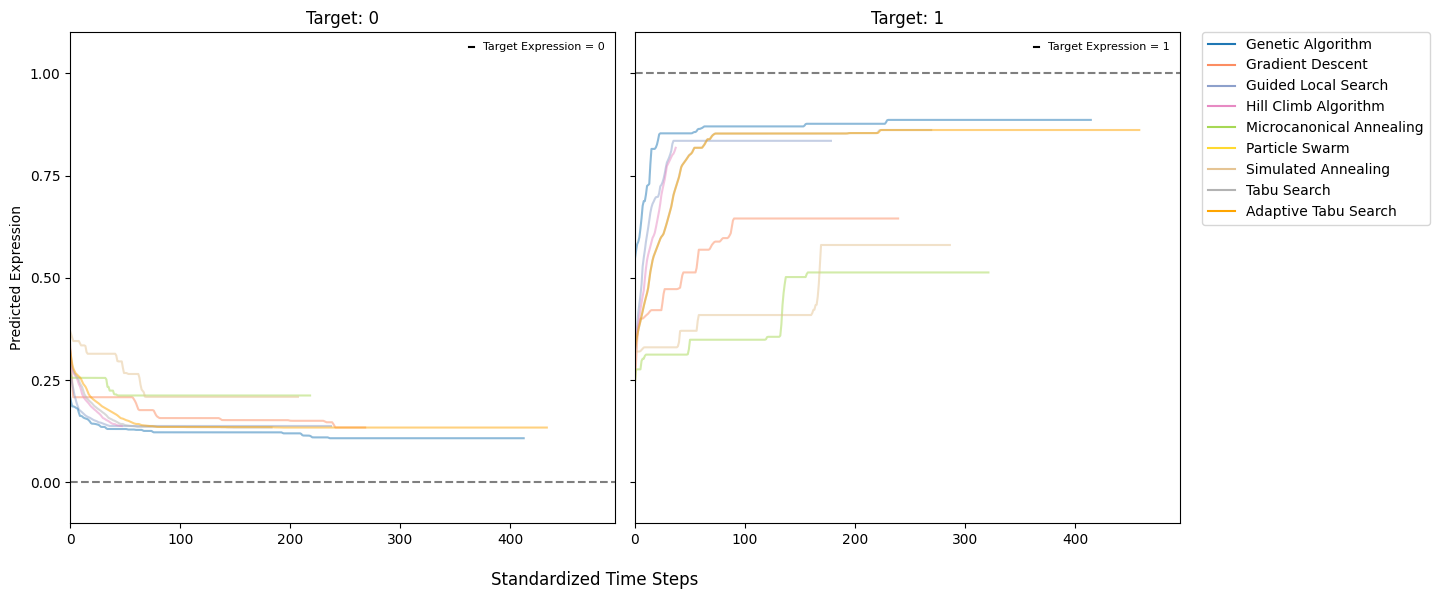

In [35]:
# -------------- Loading The Results --------------

results_df = pd.read_csv('Data/optimizer_evaluation_results.csv')
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

# exclude particle swarm
results_df = results_df[results_df['optimizer'] != 'Particle Swarm']

# get the best test for each optimizer and target expression
results_df = best_tests(results_df)

results_df['prediction_history'] = results_df.apply(
    lambda row: calculate_best_prediction_history(row['prediction_history'], row['target_expression']), axis=1
)

results_df = dynamic_standardize_prediction_history(results_df)

# stretch the lengths of each prediction_history to the maximum length
max_length = results_df['prediction_history'].apply(len).max()

# results_df['prediction_history'] = results_df['prediction_history'].apply(
#     lambda preds: preds + [preds[-1]] * (max_length - len(preds))
# )

# ---------- Define The Optimizer Colors, Order, and Target Expressions ----------

optimizer_names = optimizers.keys()

bold_optimizers = {
    'Genetic Algorithm': 'tab:blue',
    'Adaptive Tabu Search': 'orange',
}
muted_optimizers = {name: plt.cm.Set2(i) for i, name in enumerate(optimizer_names) if name not in bold_optimizers}
color_map = {**bold_optimizers, **muted_optimizers}

optimizer_plot_order = list(muted_optimizers.keys()) + list(bold_optimizers.keys())

target_expressions = [0, 1]

# -------------- Plot The Errors Over Time --------------

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
axes = axes.flatten()

for ax, target_expr in zip(axes, target_expressions):
    # plot the muted optimizers, then the bold optimizers (using optimizer_plot_order)
    for optimizer in optimizer_plot_order:
        group = results_df[
            (results_df['target_expression'] == target_expr) &
            (results_df['optimizer'] == optimizer)
        ]
        if not group.empty:
            for idx, row in group.iterrows():
                ax.plot(
                    list(range(len(row['prediction_history']))),
                    row['prediction_history'],
                    color=color_map[optimizer],
                    alpha=0.5,
                    label=optimizer
                )


    # plot target expression lines
    ax.axhline(y=target_expr, color='black', linestyle='--', alpha=0.5)

    # add a legend, but only for the target_expressions line
    labels = [f'Target Expression = {each}' for each in target_expressions if each == target_expr]
    handles = [plt.Line2D([], [], color='black', label=f'Target Expression = {target_expr}')]
    ax.legend(handles=handles, loc='upper right', fontsize=8, frameon=False, handlelength=0.5, handleheight=0.5, labelspacing=0.5)

    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(0, max_length)
    ax.set_title(f'Target: {target_expr}')

axes[0].set_yticks(np.arange(0, 1.1, 0.25))
axes[0].set_ylabel('Predicted Expression')
fig.supxlabel("Standardized Time Steps")

# add the optimizer legend
labels = [opt for opt in optimizer_names]
handles = [plt.Line2D([], [], color=color_map[opt], label=opt) for opt in optimizer_names]
fig.legend(
    handles=handles,
    labels=labels,
    loc='upper left',
    bbox_to_anchor=(1, 0.95),
    bbox_transform=fig.transFigure
)

plt.tight_layout()
plt.show()


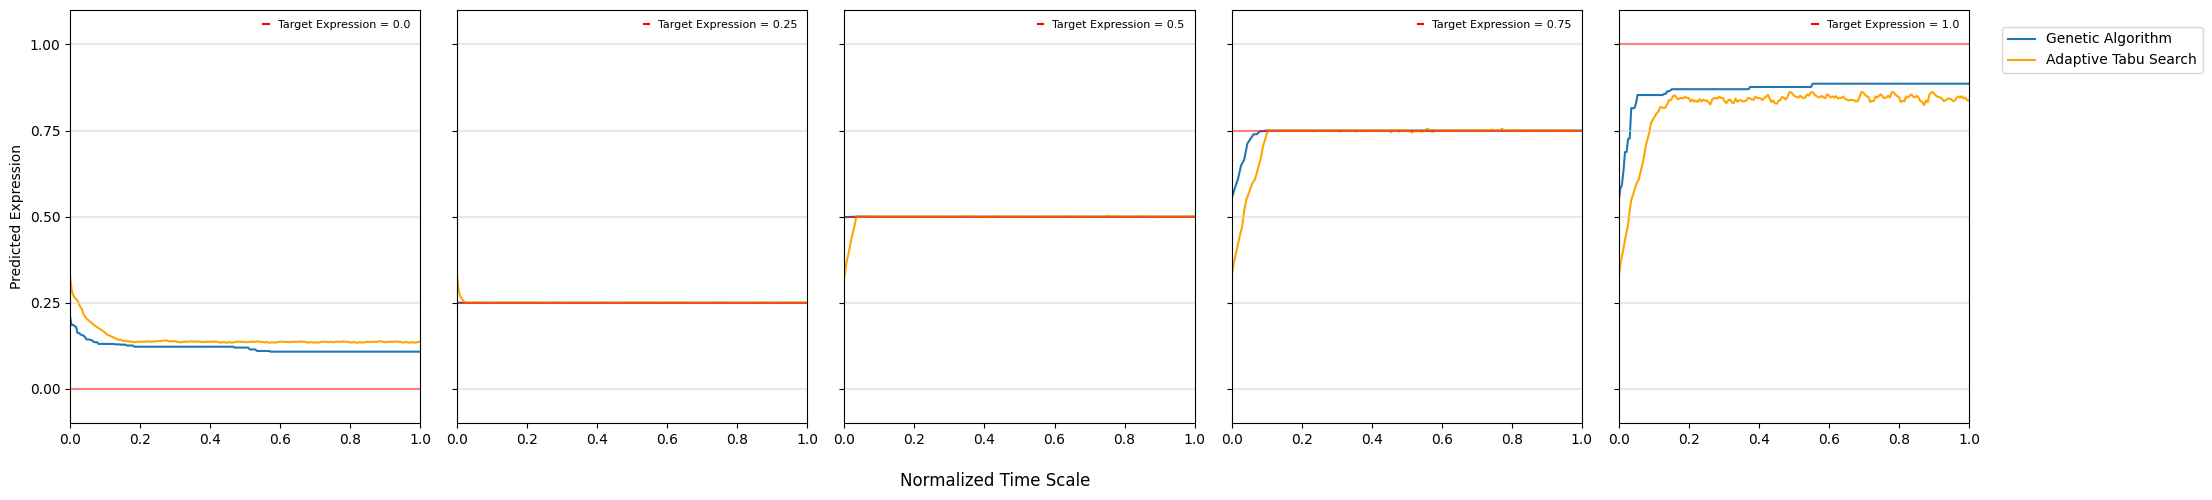

In [9]:
import ast

# -------------- Loading The Results --------------

results_df = pd.read_csv('Data/optimizer_evaluation_results.csv')
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

# get the best test for each optimizer and target expression
results_df = best_tests(results_df)

# -------------- Get The Best Test For Each Optimizer And Target Expression --------------

df_exploded = results_df.explode('prediction_history').reset_index(drop=True)
df_exploded['prediction_history'] = df_exploded['prediction_history'].astype(float)

df_exploded['iteration'] = df_exploded.groupby(['optimizer', 'target_expression']).cumcount()
group_sizes = df_exploded.groupby(['optimizer', 'target_expression'])['prediction_history'].transform('count')
df_exploded['normalized_time_scale'] = df_exploded['iteration'] / (group_sizes - 1)

# ---------- Define The Optimizer Colors, Order, and Target Expressions ----------

optimizer_names = ['Genetic Algorithm', 'Adaptive Tabu Search']

color_map = {
    'Genetic Algorithm': 'tab:blue',
    'Adaptive Tabu Search': 'orange'
}

target_expressions = df_exploded['target_expression'].unique()

# -------------- Plot The Errors Over Time --------------

fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)
axes = axes.flatten()

for ax, target_expr in zip(axes, target_expressions):
    for optimizer in optimizer_names:
        group = df_exploded[
            (df_exploded['target_expression'] == target_expr) &
            (df_exploded['optimizer'] == optimizer)
        ]
        if not group.empty:
            ax.plot(
                group['normalized_time_scale'],
                group['prediction_history'],
                color=color_map[optimizer],
                alpha=1,
                label=optimizer
            )

    # plot target expression lines
    for each in target_expressions:
        color = 'lightgrey' if each != target_expr else 'red'
        label = f'Target Expression = {each}' if each == target_expr else None
        ax.axhline(y=each, color=color, linestyle='-', alpha=0.5, label=label)

    # add a legend, but only for the target_expressions line
    labels = [f'Target Expression = {each}' for each in target_expressions if each == target_expr]
    handles = [plt.Line2D([], [], color='red', label=f'Target Expression = {target_expr}')]
    ax.legend(handles=handles, loc='upper right', fontsize=8, frameon=False, handlelength=0.5, handleheight=0.5, labelspacing=0.5)

    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(0, 1)

axes[0].set_yticks(np.arange(0, 1.1, 0.25))
axes[0].set_ylabel('Predicted Expression')
fig.supxlabel("Normalized Time Scale")

# add the optimizer legend
labels = [opt for opt in optimizer_names]
handles = [plt.Line2D([], [], color=color_map[opt], label=opt) for opt in optimizer_names]
fig.legend(
    handles=handles,
    labels=labels,
    loc='upper left',
    bbox_to_anchor=(1, 0.95),
    bbox_transform=fig.transFigure
)

plt.tight_layout()
plt.show()


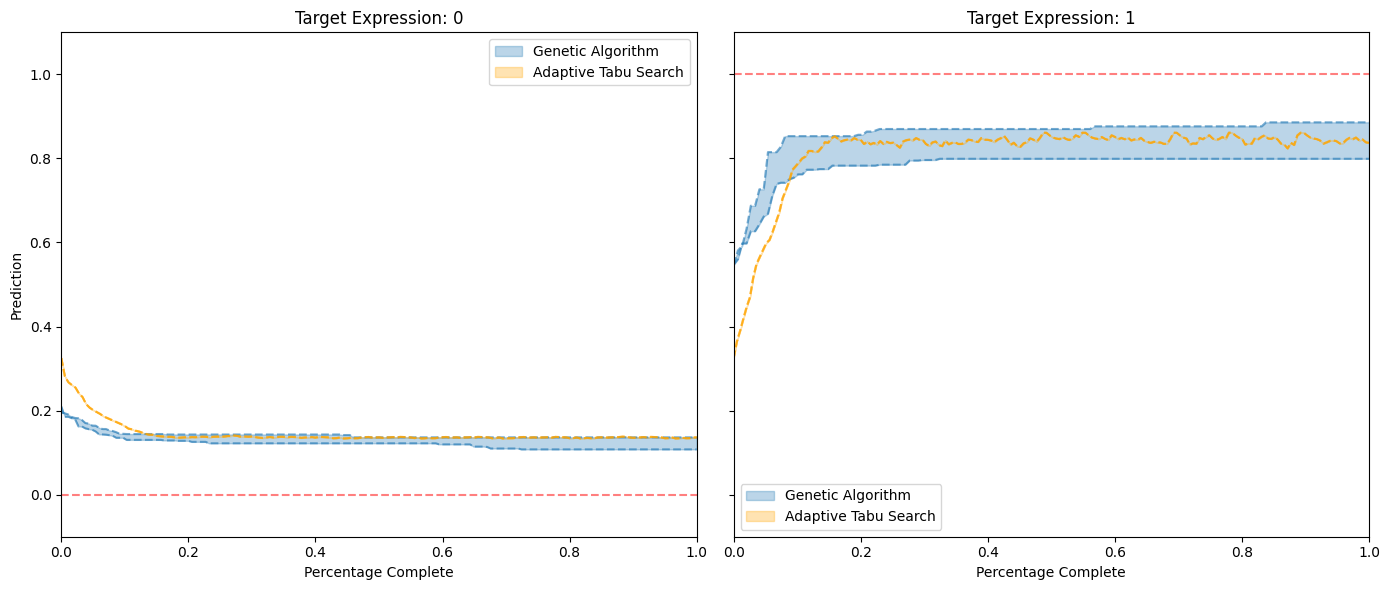

In [10]:
results_df = pd.read_csv('Data/optimizer_evaluation_results.csv')
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

# Filter only the optimizers of interest
optimizers_of_interest = ['Genetic Algorithm', 'Adaptive Tabu Search']
filtered_df = results_df[results_df['optimizer'].isin(optimizers_of_interest)].copy()

# Compute percentage complete per optimizer/target_expression group
filtered_df['normalized_time_scale'] = filtered_df.groupby(
    ['optimizer', 'target_expression']
)['iteration'].transform(lambda x: x / x.max())

# Setup the plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
target_expressions = [0, 1]

color_map = {
    'Genetic Algorithm': 'tab:blue',
    'Adaptive Tabu Search': 'orange'
}

for idx, target in enumerate(target_expressions):
    ax = axes[idx]
    ax.set_title(f'Target Expression: {target}')
    ax.set_xlabel('Percentage Complete')
    if idx == 0:
        ax.set_ylabel('Prediction')

    for optimizer in optimizers_of_interest:
        subset = filtered_df[
            (filtered_df['optimizer'] == optimizer) &
            (filtered_df['target_expression'] == target)
        ]

        if subset.empty:
            continue

        min_row = subset.loc[subset['error'].idxmin()]
        max_row = subset.loc[subset['error'].idxmax()]

        min_hist = np.array(min_row['prediction_history'])
        max_hist = np.array(max_row['prediction_history'])

        # Ensure both histories are the same length
        min_len = min(len(min_hist), len(max_hist))
        min_hist = min_hist[:min_len]
        max_hist = max_hist[:min_len]

        # Create normalized_time_scale x-axis for the run
        x = np.linspace(0, 1, min_len)

        ax.fill_between(x, min_hist, max_hist, alpha=0.3, label=f'{optimizer}', color=color_map[optimizer])
        ax.plot(x, min_hist, linestyle='--', alpha=0.6, color=color_map[optimizer])
        ax.plot(x, max_hist, linestyle='--', alpha=0.6, color=color_map[optimizer])

    ax.axhline(y=target, color='red', linestyle='--', alpha=0.5)
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(0, 1)

    ax.legend()

plt.tight_layout()
plt.show()


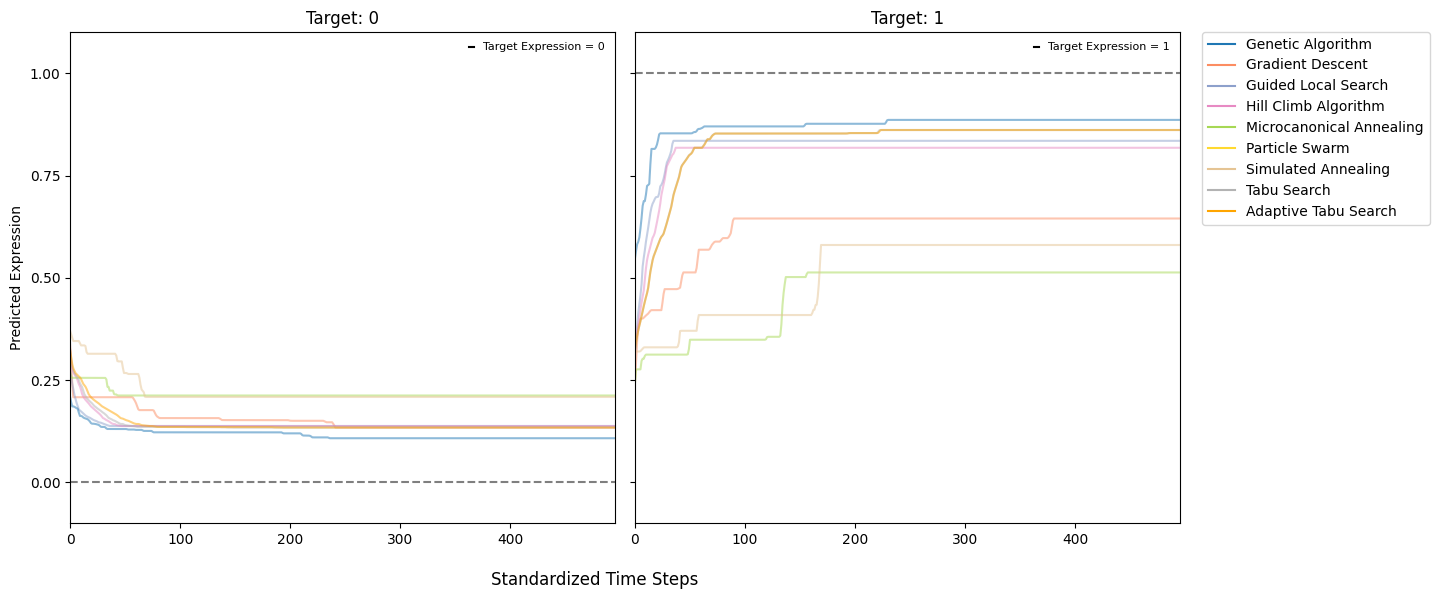

In [11]:
# -------------- Loading The Results --------------

results_df = pd.read_csv('Data/optimizer_evaluation_results.csv')
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

# exclude particle swarm
results_df = results_df[results_df['optimizer'] != 'Particle Swarm']

# get the best test for each optimizer and target expression
results_df = best_tests(results_df)

results_df['prediction_history'] = results_df.apply(
    lambda row: calculate_best_prediction_history(row['prediction_history'], row['target_expression']), axis=1
)

results_df = dynamic_standardize_prediction_history(results_df)

# stretch the lengths of each prediction_history to the maximum length
max_length = results_df['prediction_history'].apply(len).max()

results_df['prediction_history'] = results_df['prediction_history'].apply(
    lambda preds: preds + [preds[-1]] * (max_length - len(preds))
)

# ---------- Define The Optimizer Colors, Order, and Target Expressions ----------

optimizer_names = optimizers.keys()

bold_optimizers = {
    'Genetic Algorithm': 'tab:blue',
    'Adaptive Tabu Search': 'orange',
}
muted_optimizers = {name: plt.cm.Set2(i) for i, name in enumerate(optimizer_names) if name not in bold_optimizers}
color_map = {**bold_optimizers, **muted_optimizers}

optimizer_plot_order = list(muted_optimizers.keys()) + list(bold_optimizers.keys())

target_expressions = [0, 1]

# -------------- Plot The Errors Over Time --------------

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
axes = axes.flatten()

for ax, target_expr in zip(axes, target_expressions):
    # plot the muted optimizers, then the bold optimizers (using optimizer_plot_order)
    for optimizer in optimizer_plot_order:
        group = results_df[
            (results_df['target_expression'] == target_expr) &
            (results_df['optimizer'] == optimizer)
        ]
        if not group.empty:
            for idx, row in group.iterrows():
                ax.plot(
                    list(range(len(row['prediction_history']))),
                    row['prediction_history'],
                    color=color_map[optimizer],
                    alpha=0.5,
                    label=optimizer
                )


    # plot target expression lines
    ax.axhline(y=target_expr, color='black', linestyle='--', alpha=0.5)

    # add a legend, but only for the target_expressions line
    labels = [f'Target Expression = {each}' for each in target_expressions if each == target_expr]
    handles = [plt.Line2D([], [], color='black', label=f'Target Expression = {target_expr}')]
    ax.legend(handles=handles, loc='upper right', fontsize=8, frameon=False, handlelength=0.5, handleheight=0.5, labelspacing=0.5)

    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(0, max_length)
    ax.set_title(f'Target: {target_expr}')

axes[0].set_yticks(np.arange(0, 1.1, 0.25))
axes[0].set_ylabel('Predicted Expression')
fig.supxlabel("Standardized Time Steps")

# add the optimizer legend
labels = [opt for opt in optimizer_names]
handles = [plt.Line2D([], [], color=color_map[opt], label=opt) for opt in optimizer_names]
fig.legend(
    handles=handles,
    labels=labels,
    loc='upper left',
    bbox_to_anchor=(1, 0.95),
    bbox_transform=fig.transFigure
)

plt.tight_layout()
plt.show()


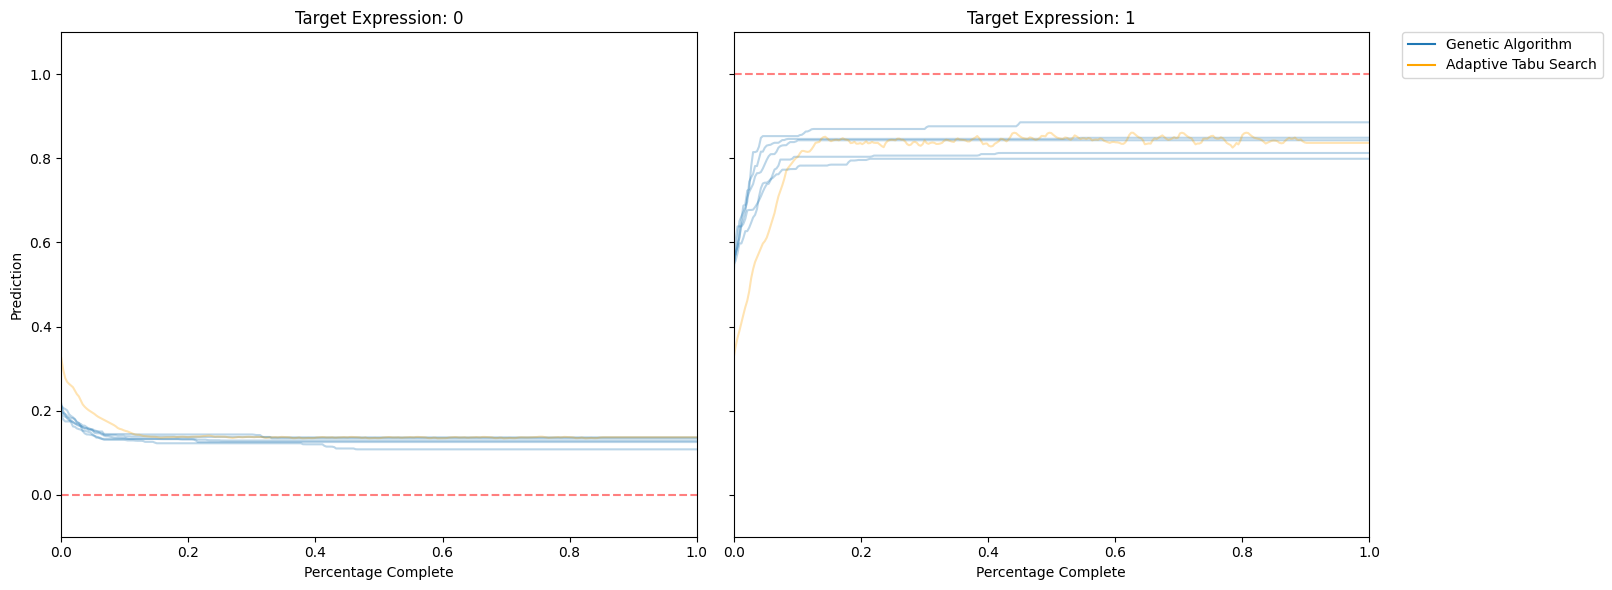

In [12]:
# Load and parse list-like columns
results_df = pd.read_csv('Data/optimizer_evaluation_results.csv')
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

# Filter only the optimizers of interest
optimizers_of_interest = ['Genetic Algorithm', 'Adaptive Tabu Search']
filtered_df = results_df[results_df['optimizer'].isin(optimizers_of_interest)].copy()

filtered_df = dynamic_standardize_prediction_history(filtered_df)

# stretch the lengths of each prediction_history to the maximum length
max_length = filtered_df['prediction_history'].apply(len).max()

filtered_df['prediction_history'] = filtered_df['prediction_history'].apply(
    lambda preds: preds + [preds[-1]] * (max_length - len(preds))
)

# Setup the plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
target_expressions = [0, 1]

color_map = {
    'Genetic Algorithm': 'tab:blue',
    'Adaptive Tabu Search': 'orange'
}

for idx, target in enumerate(target_expressions):
    ax = axes[idx]
    ax.set_title(f'Target Expression: {target}')
    ax.set_xlabel('Percentage Complete')
    if idx == 0:
        ax.set_ylabel('Prediction')

    for optimizer in optimizers_of_interest:
        subset = filtered_df[
            (filtered_df['optimizer'] == optimizer) &
            (filtered_df['target_expression'] == target)
        ]

        for _, row in subset.iterrows():
            prediction_history = np.array(row['prediction_history'])
            x = np.linspace(0, 1, len(prediction_history))
            ax.plot(x, prediction_history, color=color_map[optimizer], alpha=0.3)
    
    ax.axhline(y=target, color='red', linestyle='--', alpha=0.5)
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(0, 1)

handles = [plt.Line2D([], [], color=color_map[opt], label=opt) for opt in optimizers_of_interest]
fig.legend(
    handles=handles,
    labels=optimizers_of_interest,
    loc='upper left',
    bbox_to_anchor=(1, 0.95),
    bbox_transform=fig.transFigure
)

plt.tight_layout()
plt.show()


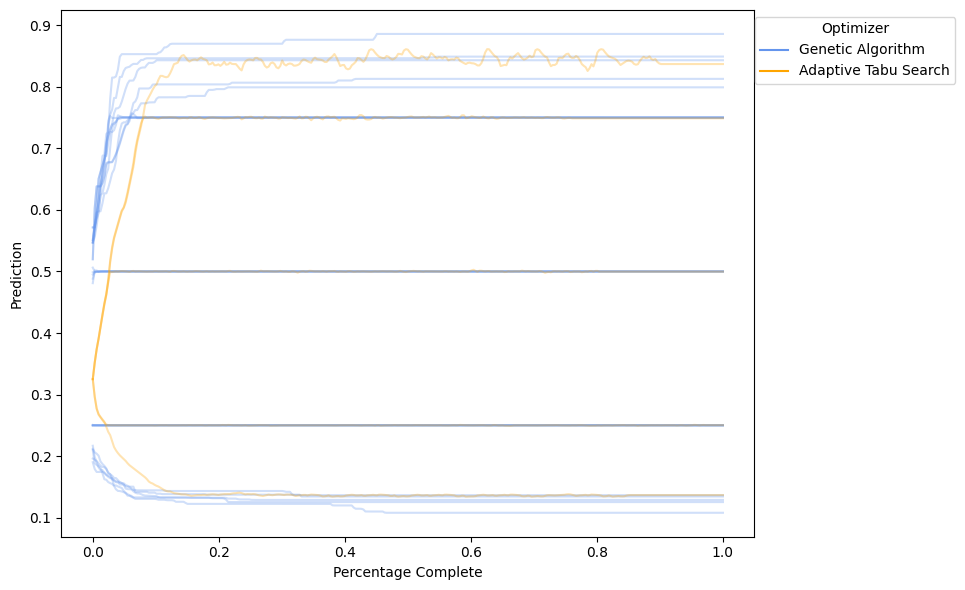

In [13]:
# Load and parse list-like columns
results_df = pd.read_csv('Data/optimizer_evaluation_results.csv')
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

# Filter only the optimizers of interest
optimizers_of_interest = ['Genetic Algorithm', 'Adaptive Tabu Search']
filtered_df = results_df[results_df['optimizer'].isin(optimizers_of_interest)].copy()

filtered_df = dynamic_standardize_prediction_history(filtered_df)

# stretch the lengths of each prediction_history to the maximum length
max_length = filtered_df['prediction_history'].apply(len).max()

filtered_df['prediction_history'] = filtered_df['prediction_history'].apply(
    lambda preds: preds + [preds[-1]] * (max_length - len(preds))
)

target_expressions = sorted(results_df['target_expression'].unique())

# Color map for target_expression values
color_map = {
    'Genetic Algorithm': 'cornflowerblue',
    'Adaptive Tabu Search': 'orange',
}

# Set up the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot all runs
for optimizer in optimizers_of_interest:
    for target in target_expressions:
        subset = filtered_df[
            (filtered_df['optimizer'] == optimizer) &
            (filtered_df['target_expression'] == target)
        ]

        for _, row in subset.iterrows():
            prediction_history = np.array(row['prediction_history'])
            x = np.linspace(0, 1, len(prediction_history))  # percentage complete
            ax.plot(x, prediction_history, color=color_map.get(optimizer, 'gray'), alpha=0.3)

# Create custom legend
handles = [plt.Line2D([], [], color=color_map[optimizer], label=str(optimizer)) for optimizer in optimizers_of_interest]

# put legend outside the plot
ax.legend(handles=handles, title="Optimizer", loc='upper right', bbox_to_anchor=(1.3, 1))

ax.set_xlabel("Percentage Complete")
ax.set_ylabel("Prediction")

plt.tight_layout()
plt.show()


In [ ]:
# Load and parse list-like columns
results_df = pd.read_csv('Data/optimizer_evaluation_results.csv')
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

# Filter only the optimizers of interest
optimizers_of_interest = ['Genetic Algorithm', 'Adaptive Tabu Search']
filtered_df = results_df[results_df['optimizer'].isin(optimizers_of_interest)].copy()

filtered_df = dynamic_standardize_prediction_history(filtered_df)

# stretch the lengths of each prediction_history to the maximum length
max_length = filtered_df['prediction_history'].apply(len).max()

filtered_df['prediction_history'] = filtered_df['prediction_history'].apply(
    lambda preds: preds + [preds[-1]] * (max_length - len(preds))
)

target_expressions = sorted(results_df['target_expression'].unique())

# Color map for target_expression values
color_map = {
    'Genetic Algorithm': 'cornflowerblue',
    'Adaptive Tabu Search': 'orange',
}

# Set up the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot all runs
for optimizer in optimizers_of_interest:
    for target in target_expressions:
        subset = filtered_df[
            (filtered_df['optimizer'] == optimizer) &
            (filtered_df['target_expression'] == target)
        ]

        for _, row in subset.iterrows():
            prediction_history = np.array(row['prediction_history'])
            x = np.linspace(0, 1, len(prediction_history))  # percentage complete
            ax.plot(x, prediction_history, color=color_map.get(optimizer, 'gray'), alpha=0.3)

# Create custom legend
handles = [plt.Line2D([], [], color=color_map[optimizer], label=str(optimizer)) for optimizer in optimizers_of_interest]

# put legend outside the plot
ax.legend(handles=handles, title="Optimizer", loc='upper right', bbox_to_anchor=(1.3, 1))

ax.set_xlabel("Percentage Complete")
ax.set_ylabel("Prediction")

plt.tight_layout()
plt.show()


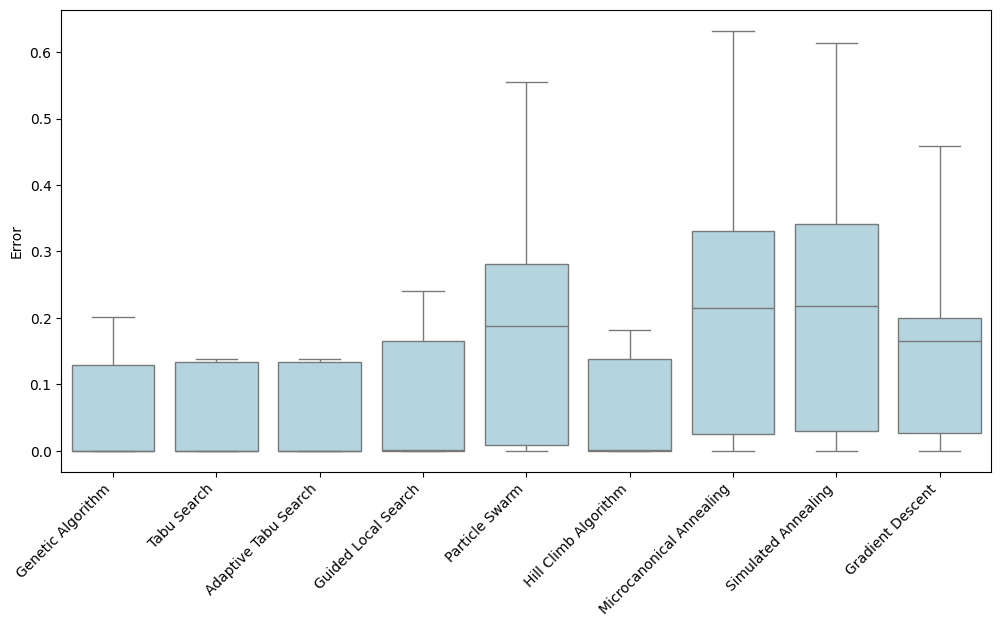

In [14]:
results_df = pd.read_csv('Data/optimizer_evaluation_results.csv')
results_df = results_df.sort_values(by='error')

# Plotting the error for each optimizer
plt.figure(figsize=(12, 6))
sns.boxplot(x='optimizer', y='error', data=results_df, color='lightblue',
            order=results_df['optimizer'].unique())
plt.xlabel('')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Error')
plt.show()


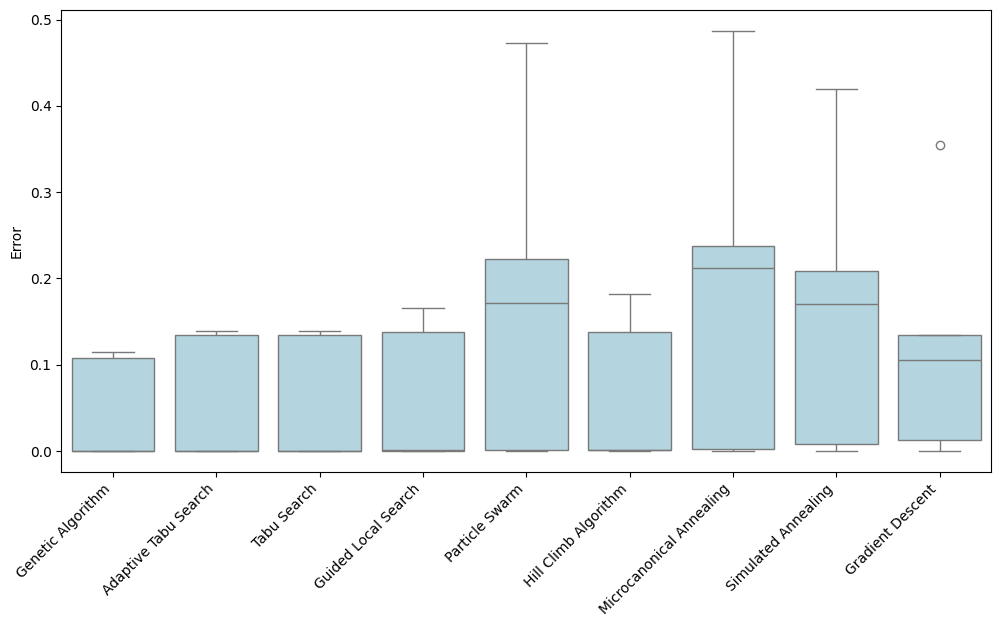

In [15]:
results_df = pd.read_csv('Data/optimizer_evaluation_results.csv')

# Get the best test for each optimizer and target expression (without)
grouped = results_df.groupby(['optimizer', 'target_expression'])
best_rows = []
for (optimizer, target), group in grouped:
    best_error_idx = group['error'].idxmin()
    best_row = group.loc[best_error_idx]

    best_rows.append({
        'optimizer': optimizer,
        'target_expression': target,
        'prediction': best_row['prediction'],
        'error': best_row['error'],
    })

results_df =  pd.DataFrame(best_rows)
results_df = results_df.sort_values(by='error')

# Plotting the error for each optimizer
plt.figure(figsize=(12, 6))
sns.boxplot(x='optimizer', y='error', data=results_df, color='lightblue',
            order=results_df['optimizer'].unique())
plt.xlabel('')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Error')
plt.show()


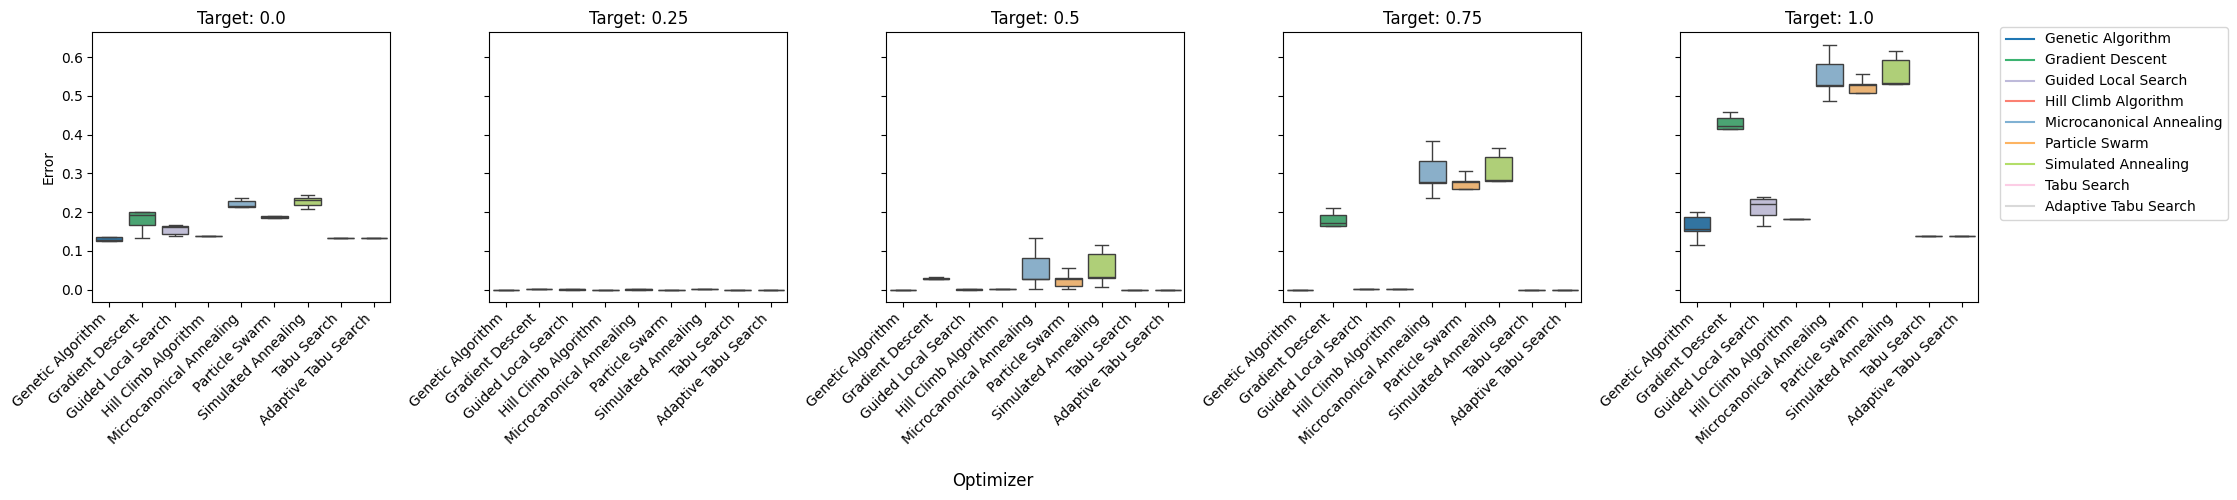

In [16]:
# Load data
results_df = pd.read_csv('Data/optimizer_evaluation_results.csv')

target_expressions = results_df['target_expression'].unique()
num_targets = len(target_expressions)

# Grid layout
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)
axes = axes.flatten()

optimizer_names = results_df['optimizer'].unique()

# Define consistent color map per optimizer
bold_optimizers = {
    'Genetic Algorithm': 'tab:blue',
    'Gradient Descent': 'mediumseagreen'
}
muted_optimizers = {name: plt.cm.Set3(i) for i, name in enumerate(optimizer_names) if name not in bold_optimizers}
color_map = {**bold_optimizers, **muted_optimizers}

# Plot each target expression
for i, target_expr in enumerate(target_expressions):
    sns.boxplot(
        x='optimizer',
        y='error',
        hue='optimizer',
        data=results_df[results_df['target_expression'] == target_expr],
        ax=axes[i],
        palette=color_map,
        showfliers=False
    )
    axes[i].set_title(f'Target: {target_expr}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Error')
    axes[i].set_xticks(range(len(optimizer_names)))
    axes[i].set_xticklabels(optimizer_names, rotation=45, ha='right')

fig.supxlabel("Optimizer")

# add the optimizer legend
labels = [opt for opt in optimizer_names]
handles = [plt.Line2D([], [], color=color_map[opt], label=opt) for opt in optimizer_names]
fig.legend(
    handles=handles,
    labels=labels,
    loc='upper left',
    bbox_to_anchor=(1, 0.95),
    bbox_transform=fig.transFigure
)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

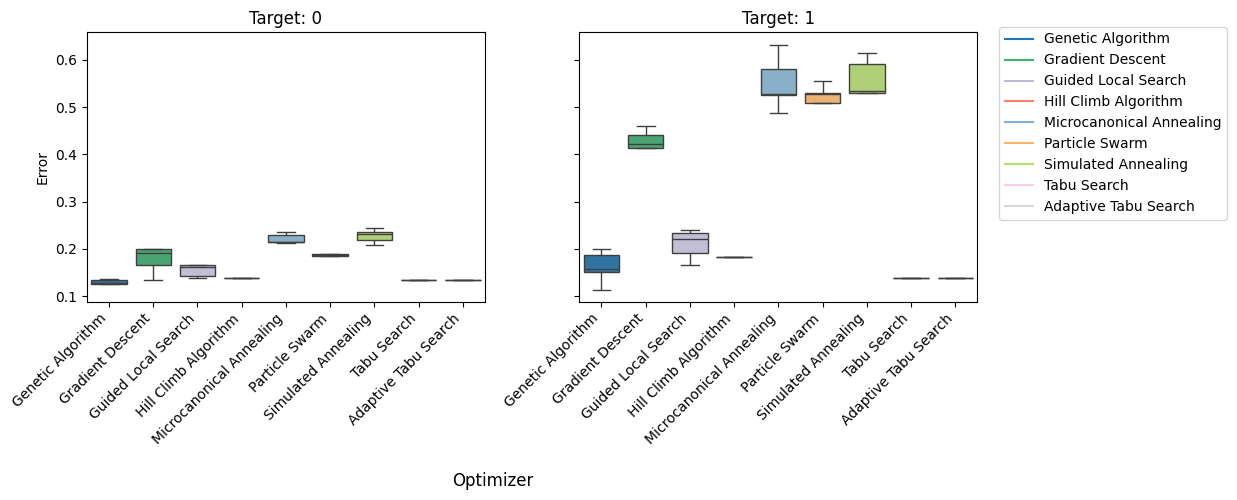

In [54]:
# Load data
results_df = pd.read_csv('Data/optimizer_evaluation_results.csv')

target_expressions = [0, 1]
num_targets = len(target_expressions)

# Grid layout
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
axes = axes.flatten()

optimizer_names = results_df['optimizer'].unique()

# Define consistent color map per optimizer
bold_optimizers = {
    'Genetic Algorithm': 'tab:blue',
    'Gradient Descent': 'mediumseagreen'
}
muted_optimizers = {name: plt.cm.Set3(i) for i, name in enumerate(optimizer_names) if name not in bold_optimizers}
color_map = {**bold_optimizers, **muted_optimizers}

# Plot each target expression
for i, target_expr in enumerate(target_expressions):
    sns.boxplot(
        x='optimizer',
        y='error',
        hue='optimizer',
        data=results_df[results_df['target_expression'] == target_expr],
        ax=axes[i],
        palette=color_map,
        showfliers=False
    )
    axes[i].set_title(f'Target: {target_expr}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Error')
    axes[i].set_xticks(range(len(optimizer_names)))
    axes[i].set_xticklabels(optimizer_names, rotation=45, ha='right')

fig.supxlabel("Optimizer")

# add the optimizer legend
labels = [opt for opt in optimizer_names]
handles = [plt.Line2D([], [], color=color_map[opt], label=opt) for opt in optimizer_names]
fig.legend(
    handles=handles,
    labels=labels,
    loc='upper left',
    bbox_to_anchor=(1, 0.95),
    bbox_transform=fig.transFigure
)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

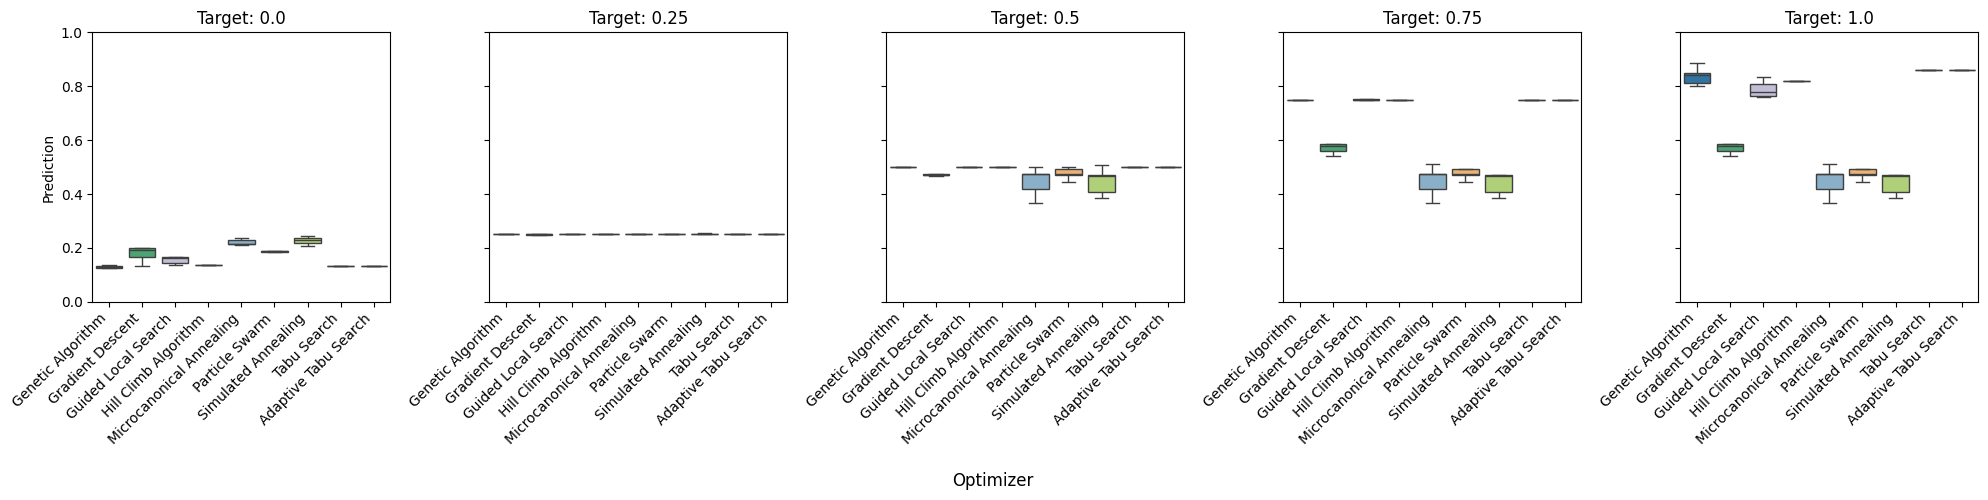

In [17]:
# Load data
results_df = pd.read_csv('Data/optimizer_evaluation_results.csv')

target_expressions = results_df['target_expression'].unique()
num_targets = len(target_expressions)

# Grid layout
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)
axes = axes.flatten()

optimizer_names = results_df['optimizer'].unique()

# Define consistent color map per optimizer
bold_optimizers = {
    'Genetic Algorithm': 'tab:blue',
    'Gradient Descent': 'mediumseagreen'
}
muted_optimizers = {name: plt.cm.Set3(i) for i, name in enumerate(optimizer_names) if name not in bold_optimizers}
color_map = {**bold_optimizers, **muted_optimizers}

# Plot each target expression
for i, target_expr in enumerate(target_expressions):
    sns.boxplot(
        x='optimizer',
        y='prediction',
        hue='optimizer',
        data=results_df[results_df['target_expression'] == target_expr],
        ax=axes[i],
        palette=color_map,
        showfliers=False
    )
    axes[i].set_title(f'Target: {target_expr}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Prediction')
    axes[i].set_ylim(0, 1)
    axes[i].set_xticks(range(len(optimizer_names)))
    axes[i].set_xticklabels(optimizer_names, rotation=45, ha='right')

fig.supxlabel("Optimizer")

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

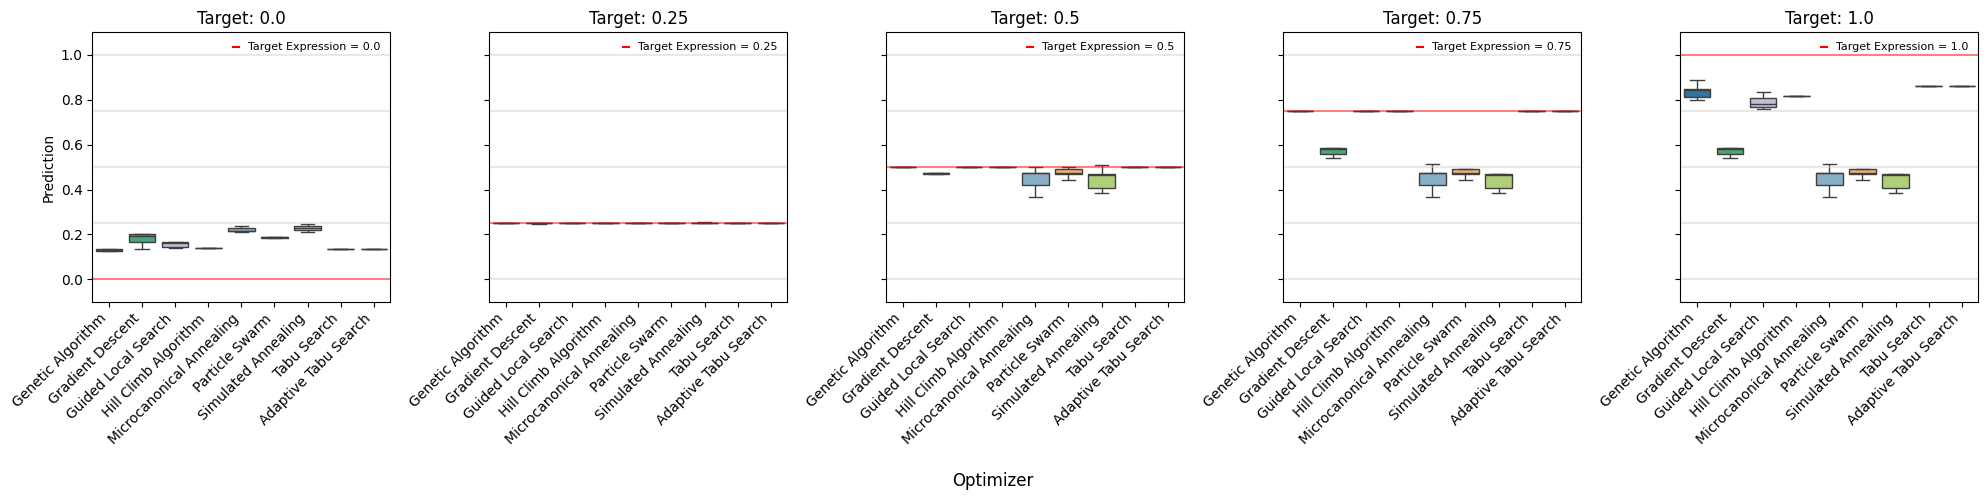

In [18]:
# Load data
results_df = pd.read_csv('Data/optimizer_evaluation_results.csv')

target_expressions = results_df['target_expression'].unique()
num_targets = len(target_expressions)

# Grid layout
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)
axes = axes.flatten()

optimizer_names = results_df['optimizer'].unique()

# Define consistent color map per optimizer
bold_optimizers = {
    'Genetic Algorithm': 'tab:blue',
    'Gradient Descent': 'mediumseagreen'
}
muted_optimizers = {name: plt.cm.Set3(i) for i, name in enumerate(optimizer_names) if name not in bold_optimizers}
color_map = {**bold_optimizers, **muted_optimizers}

# Plot each target expression
for i, target_expr in enumerate(target_expressions):
    sns.boxplot(
        x='optimizer',
        y='prediction',
        hue='optimizer',
        data=results_df[results_df['target_expression'] == target_expr],
        ax=axes[i],
        palette=color_map,
        showfliers=False
    )
    axes[i].set_title(f'Target: {target_expr}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Prediction')
    axes[i].set_xticks(range(len(optimizer_names)))
    axes[i].set_xticklabels(optimizer_names, rotation=45, ha='right')

    # plot target expression lines
    for each in target_expressions:
        color = 'lightgrey' if each != target_expr else 'red'
        label = f'Target Expression = {each}' if each == target_expr else None
        axes[i].axhline(y=each, color=color, linestyle='-', alpha=0.5, label=label)

    # add a legend, but only for the target_expressions line
    labels = [f'Target Expression = {each}' for each in target_expressions if each == target_expr]
    handles = [plt.Line2D([], [], color='red', label=f'Target Expression = {target_expr}')]
    axes[i].legend(handles=handles, loc='upper right', fontsize=8, frameon=False, handlelength=0.5, handleheight=0.5, labelspacing=0.5)

    axes[i].set_ylim(-0.1, 1.1)
    

fig.supxlabel("Optimizer")

# add the optimizer legend
labels = [opt for opt in optimizer_names]
handles = [plt.Line2D([], [], color=color_map[opt], label=opt) for opt in optimizer_names]
# fig.legend(
#     handles=handles,
#     labels=labels,
#     loc='upper left',
#     bbox_to_anchor=(1, 0.95),
#     bbox_transform=fig.transFigure
# )

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

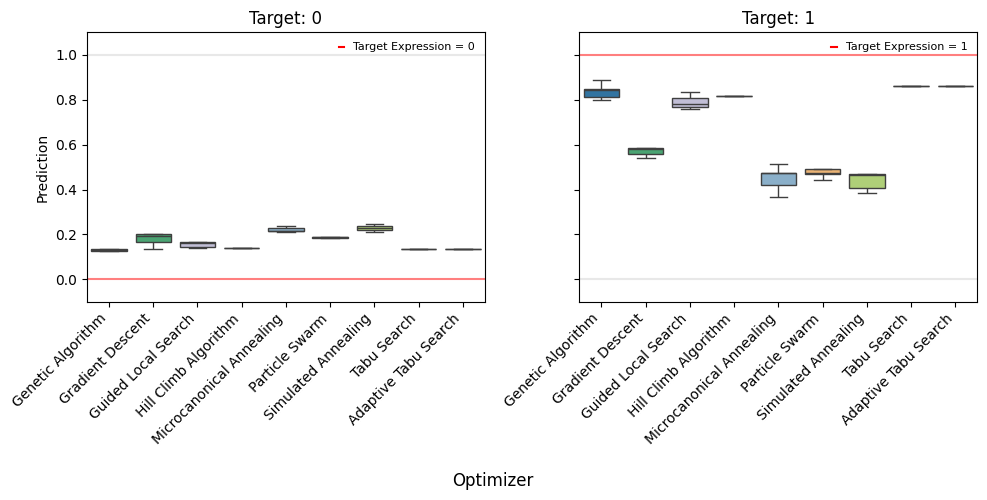

In [55]:
# Load data
results_df = pd.read_csv('Data/optimizer_evaluation_results.csv')

target_expressions = [0, 1]
num_targets = len(target_expressions)

# Grid layout
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
axes = axes.flatten()

optimizer_names = results_df['optimizer'].unique()

# Define consistent color map per optimizer
bold_optimizers = {
    'Genetic Algorithm': 'tab:blue',
    'Gradient Descent': 'mediumseagreen'
}
muted_optimizers = {name: plt.cm.Set3(i) for i, name in enumerate(optimizer_names) if name not in bold_optimizers}
color_map = {**bold_optimizers, **muted_optimizers}

# Plot each target expression
for i, target_expr in enumerate(target_expressions):
    sns.boxplot(
        x='optimizer',
        y='prediction',
        hue='optimizer',
        data=results_df[results_df['target_expression'] == target_expr],
        ax=axes[i],
        palette=color_map,
        showfliers=False
    )
    axes[i].set_title(f'Target: {target_expr}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Prediction')
    axes[i].set_xticks(range(len(optimizer_names)))
    axes[i].set_xticklabels(optimizer_names, rotation=45, ha='right')

    # plot target expression lines
    for each in target_expressions:
        color = 'lightgrey' if each != target_expr else 'red'
        label = f'Target Expression = {each}' if each == target_expr else None
        axes[i].axhline(y=each, color=color, linestyle='-', alpha=0.5, label=label)

    # add a legend, but only for the target_expressions line
    labels = [f'Target Expression = {each}' for each in target_expressions if each == target_expr]
    handles = [plt.Line2D([], [], color='red', label=f'Target Expression = {target_expr}')]
    axes[i].legend(handles=handles, loc='upper right', fontsize=8, frameon=False, handlelength=0.5, handleheight=0.5, labelspacing=0.5)

    axes[i].set_ylim(-0.1, 1.1)
    

fig.supxlabel("Optimizer")

# add the optimizer legend
labels = [opt for opt in optimizer_names]
handles = [plt.Line2D([], [], color=color_map[opt], label=opt) for opt in optimizer_names]
# fig.legend(
#     handles=handles,
#     labels=labels,
#     loc='upper left',
#     bbox_to_anchor=(1, 0.95),
#     bbox_transform=fig.transFigure
# )

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

### Hamming Distance
---

In [74]:
print(len(kwargs['masked_sequence']))
print(kwargs['masked_sequence'].count('N'))

75
30


In [19]:
def hamming_distance(seq1, seq2):
    min_length = min(len(seq1), len(seq2))
    max_length = max(len(seq1), len(seq2))
    return sum(c1 != c2 for c1, c2 in zip(seq1[:min_length], seq2[:min_length])) + (max_length - min_length)


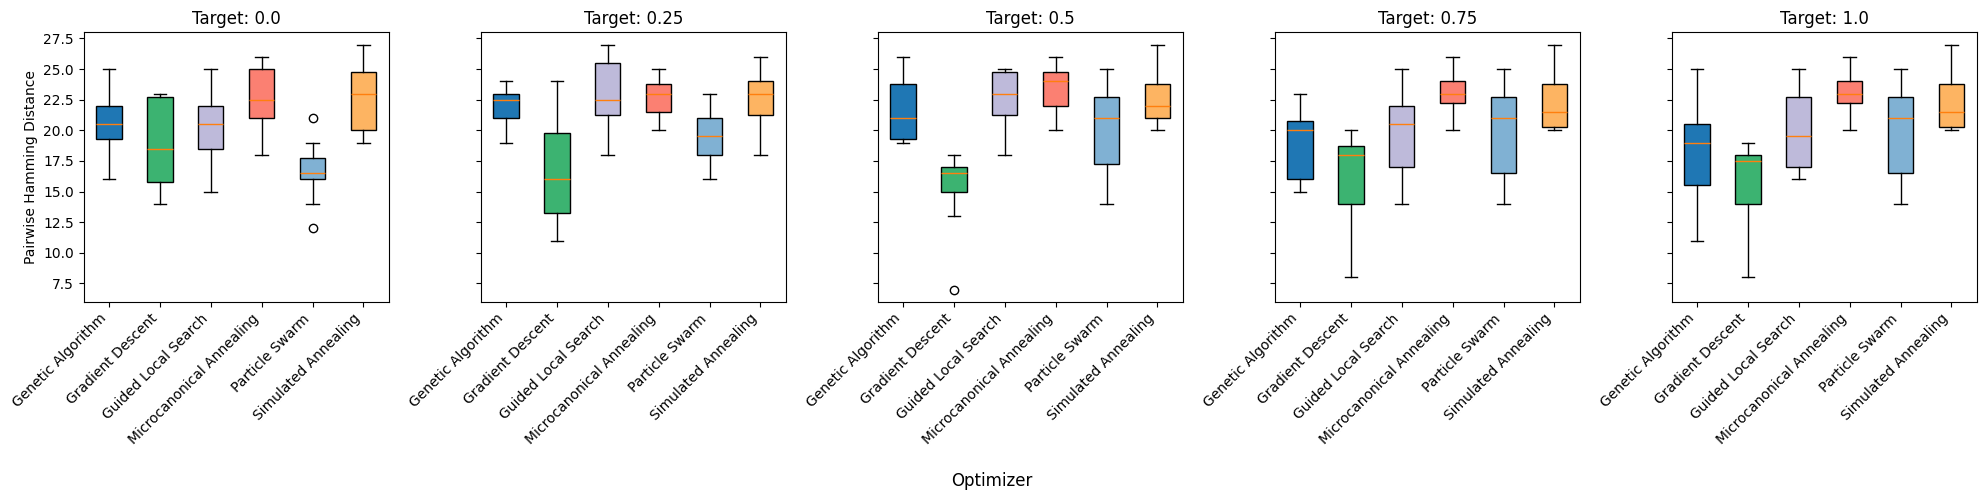

In [50]:
from itertools import combinations

# Load data
results_df = pd.read_csv('Data/optimizer_evaluation_results.csv')

target_expressions = results_df['target_expression'].unique()

# Grid layout
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)
axes = axes.flatten()

# get optimizer names, but exclude deterministic optimizers
optimizer_names = results_df['optimizer'].unique()
optimizer_names = [name for name in optimizer_names if name not in ['Hill Climb Algorithm', 'Tabu Search', 'Adaptive Tabu Search']]

# Bold, muted colors for optimizers
bold_optimizers = {
    'Genetic Algorithm': 'tab:blue',
    'Gradient Descent': 'mediumseagreen'
}
muted_optimizers = {name: plt.cm.Set3(i) for i, name in enumerate(optimizer_names) if name not in bold_optimizers}
color_map = {**bold_optimizers, **muted_optimizers}

# Plot the boxplot distribution of pairwise hamming distances for every optimizer and target expression combination
for i, target in enumerate(target_expressions):
    ax = axes[i]
    target_df = results_df[results_df['target_expression'] == target]
    
    data_to_plot = []
    
    for opt in optimizer_names:
        opt_df = target_df[target_df['optimizer'] == opt]
        sequences = opt_df['sequence'].values
        hamming_distances = []
        
        for seq1, seq2 in combinations(sequences, 2):
            hamming_distances.append(hamming_distance(seq1, seq2))
        
        data_to_plot.append(hamming_distances)
    
    # Boxplot
    bp = ax.boxplot(data_to_plot, patch_artist=True)
    
    # Color the boxes
    for patch, opt in zip(bp['boxes'], optimizer_names):
        patch.set_facecolor(color_map[opt])
    
    ax.set_title(f'Target: {target}')
    ax.set_xlabel('')
    ax.set_xticks(range(1, len(optimizer_names) + 1))
    ax.set_xticklabels(optimizer_names, rotation=45, ha='right')

    if i == 0:
        ax.set_ylabel('Pairwise Hamming Distance')

fig.supxlabel("Optimizer")

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()


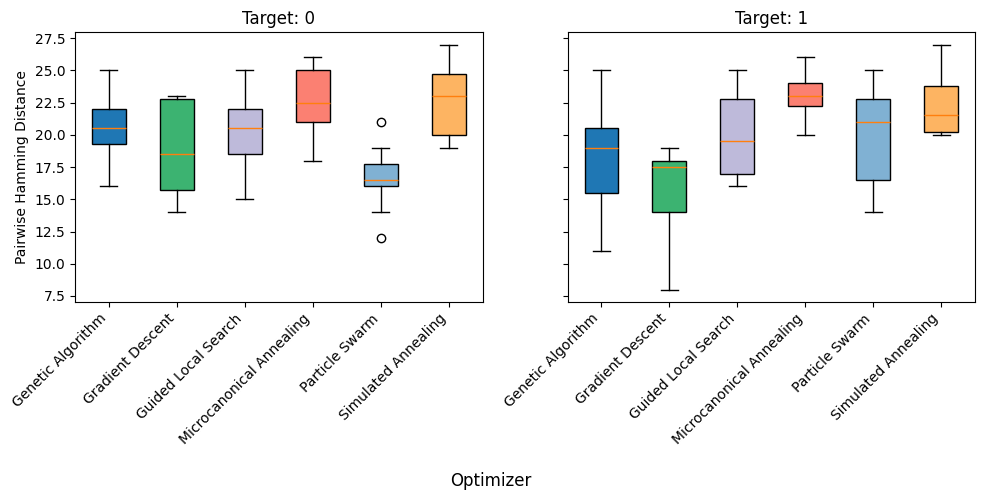

In [51]:
from itertools import combinations

# Load data
results_df = pd.read_csv('Data/optimizer_evaluation_results.csv')

target_expressions = [0, 1]

# Grid layout
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
axes = axes.flatten()

# get optimizer names, but exclude deterministic optimizers
optimizer_names = results_df['optimizer'].unique()
optimizer_names = [name for name in optimizer_names if name not in ['Hill Climb Algorithm', 'Tabu Search', 'Adaptive Tabu Search']]

# Bold, muted colors for optimizers
bold_optimizers = {
    'Genetic Algorithm': 'tab:blue',
    'Gradient Descent': 'mediumseagreen'
}
muted_optimizers = {name: plt.cm.Set3(i) for i, name in enumerate(optimizer_names) if name not in bold_optimizers}
color_map = {**bold_optimizers, **muted_optimizers}

# Plot the boxplot distribution of pairwise hamming distances for every optimizer and target expression combination
for i, target in enumerate(target_expressions):
    ax = axes[i]
    target_df = results_df[results_df['target_expression'] == target]
    
    data_to_plot = []
    
    for opt in optimizer_names:
        opt_df = target_df[target_df['optimizer'] == opt]
        sequences = opt_df['sequence'].values
        hamming_distances = []
        
        for seq1, seq2 in combinations(sequences, 2):
            hamming_distances.append(hamming_distance(seq1, seq2))
        
        data_to_plot.append(hamming_distances)
    
    # Boxplot
    bp = ax.boxplot(data_to_plot, patch_artist=True)
    
    # Color the boxes
    for patch, opt in zip(bp['boxes'], optimizer_names):
        patch.set_facecolor(color_map[opt])
    
    ax.set_title(f'Target: {target}')
    ax.set_xlabel('')
    ax.set_xticks(range(1, len(optimizer_names) + 1))
    ax.set_xticklabels(optimizer_names, rotation=45, ha='right')

    if i == 0:
        ax.set_ylabel('Pairwise Hamming Distance')

fig.supxlabel("Optimizer")

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()


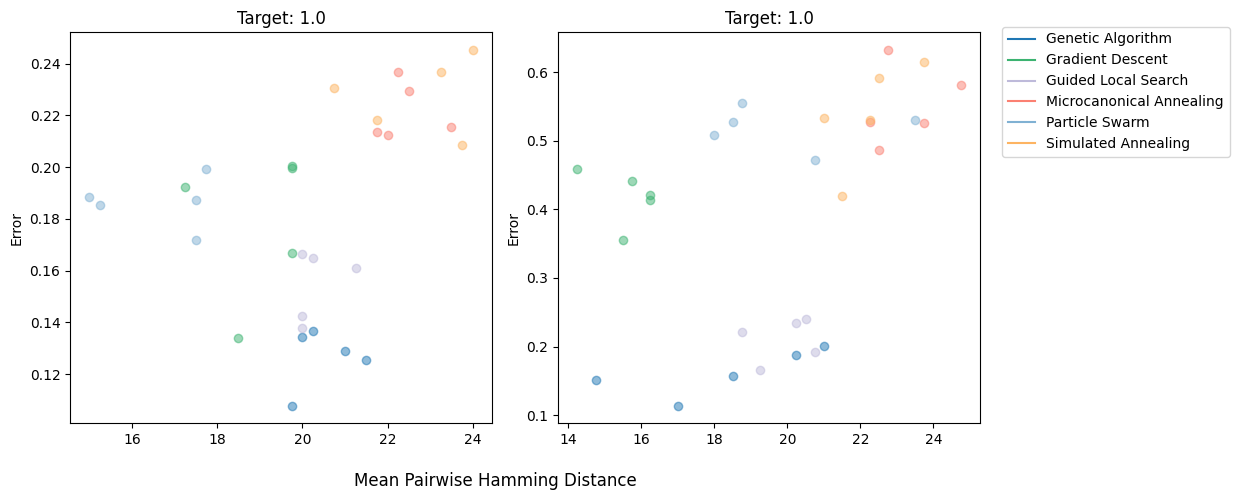

In [34]:
from itertools import combinations

# Load data
results_df = pd.read_csv('Data/optimizer_evaluation_results.csv')

target_expressions = [0, 1]

# Grid layout
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.flatten()

# get optimizer names, but exclude deterministic optimizers
optimizer_names = results_df['optimizer'].unique()
optimizer_names = [name for name in optimizer_names if name not in ['Hill Climb Algorithm', 'Tabu Search', 'Adaptive Tabu Search']]

# Bold, muted colors for optimizers
bold_optimizers = {
    'Genetic Algorithm': 'tab:blue',
    'Gradient Descent': 'mediumseagreen'
}
muted_optimizers = {name: plt.cm.Set3(i) for i, name in enumerate(optimizer_names) if name not in bold_optimizers}
color_map = {**bold_optimizers, **muted_optimizers}

for i, target in enumerate(target_expressions):
    ax = axes[i]
    target_df = results_df[results_df['target_expression'] == target]
    
    for opt in optimizer_names:
        opt_df = target_df[target_df['optimizer'] == opt]
        sequences = opt_df['sequence'].values
        errors = opt_df['error'].values
        hamming_distances = {}
        
        for i, seq1 in enumerate(sequences):
            for seq2 in sequences:
                if seq1 != seq2:
                    dist = hamming_distance(seq1, seq2)
                    if seq1 not in hamming_distances:
                        hamming_distances[seq1] = []
                    hamming_distances[seq1].append(dist)
            
            mean_distance = np.mean(hamming_distances[seq1])

            # plot a scatter point for each sequence's mean  hamming distance and error
            ax.scatter(mean_distance, errors[i], color=color_map[opt], alpha=0.5)

    ax.set_title(f'Target: {target_expr}')
    ax.set_ylabel('Error')
            
    if i == 0:
        ax.set_ylabel('Pairwise Hamming Distance')

fig.supxlabel("Mean Pairwise Hamming Distance")

# add the optimizer legend
labels = [opt for opt in optimizer_names]
handles = [plt.Line2D([], [], color=color_map[opt], label=opt) for opt in optimizer_names]
fig.legend(
    handles=handles,
    labels=labels,
    loc='upper left',
    bbox_to_anchor=(1, 0.95),
    bbox_transform=fig.transFigure
)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()


In [71]:
results_df = pd.read_csv('Data/optimizer_evaluation_results.csv')
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

results_df = best_tests(results_df)

results_df = results_df[results_df['target_expression'] == 0]

# optimizers = results_df['optimizer'].unique()
optimizers = ['Tabu Search', 'Guided Local Search', 'Hill Climb Algorithm', 'Gradient Descent']

for optimizer in optimizers:
    average_distance = 0
    seq1 = results_df[results_df['optimizer'] == optimizer]['sequence'].values[0]
    for seq2 in results_df['sequence'].values:
        if seq1 != seq2:
            dist = hamming_distance(seq1, seq2)
            average_distance += dist
    average_distance /= len(results_df['sequence'].values) - 1
    print(f"{optimizer}: {average_distance:.2f}")

Tabu Search: 17.25
Guided Local Search: 18.88
Hill Climb Algorithm: 20.50
Gradient Descent: 17.88


In [73]:
results_df = pd.read_csv('Data/optimizer_evaluation_results.csv')
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

results_df = best_tests(results_df)

results_df = results_df[results_df['target_expression'] == 0]

optimizers = results_df['optimizer'].unique()
optimizers = ['Tabu Search', 'Guided Local Search', 'Hill Climb Algorithm', 'Gradient Descent']

for optimizer1 in optimizers:
    for optimizer2 in optimizers:
        if optimizer1 == optimizer2:
            continue
        seq1 = results_df[results_df['optimizer'] == optimizer1]['sequence'].values[0]
        seq2 = results_df[results_df['optimizer'] == optimizer2]['sequence'].values[0]
        distance = hamming_distance(seq1, seq2)
        print(f'{optimizer1} | {optimizer2} = {distance}')
    print()

Tabu Search | Guided Local Search = 18
Tabu Search | Hill Climb Algorithm = 13
Tabu Search | Gradient Descent = 18

Guided Local Search | Tabu Search = 18
Guided Local Search | Hill Climb Algorithm = 22
Guided Local Search | Gradient Descent = 18

Hill Climb Algorithm | Tabu Search = 13
Hill Climb Algorithm | Guided Local Search = 22
Hill Climb Algorithm | Gradient Descent = 20

Gradient Descent | Tabu Search = 18
Gradient Descent | Guided Local Search = 18
Gradient Descent | Hill Climb Algorithm = 20



In [92]:
# Load and preprocess the data
results_df = pd.read_csv('Data/optimizer_evaluation_results.csv')
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

results_df = best_tests(results_df)

target_expressions = results_df['target_expression'].unique()

hamming_dfs = {}

for target in target_expressions:
    target_df = results_df[results_df['target_expression'] == target]

    error_means = target_df.groupby('optimizer')['error'].mean()
    sorted_optimizers = error_means.sort_values().index.tolist()

    hamming_matrix = pd.DataFrame(index=sorted_optimizers, columns=sorted_optimizers, dtype=float)

    for opt1, opt2 in product(sorted_optimizers, repeat=2):
        if opt1 == opt2:
            hamming_matrix.loc[opt1, opt2] = 0
        else:
            seq1 = target_df[target_df['optimizer'] == opt1]['sequence'].values[0]
            seq2 = target_df[target_df['optimizer'] == opt2]['sequence'].values[0]
            distance = hamming_distance(seq1, seq2)
            hamming_matrix.loc[opt1, opt2] = distance

    hamming_dfs[target] = hamming_matrix

hamming_dfs[0]


,Genetic Algorithm,Adaptive Tabu Search,Tabu Search,Gradient Descent,Hill Climb Algorithm,Guided Local Search,Particle Swarm,Simulated Annealing,Microcanonical Annealing
Genetic Algorithm,0.0,20.0,20.0,11.0,20.0,20.0,18.0,18.0,25.0
Adaptive Tabu Search,20.0,0.0,0.0,18.0,13.0,18.0,22.0,23.0,24.0
Tabu Search,20.0,0.0,0.0,18.0,13.0,18.0,22.0,23.0,24.0
Gradient Descent,11.0,18.0,18.0,0.0,20.0,18.0,17.0,17.0,24.0
Hill Climb Algorithm,20.0,13.0,13.0,20.0,0.0,22.0,25.0,24.0,27.0
Guided Local Search,20.0,18.0,18.0,18.0,22.0,0.0,19.0,22.0,14.0
Particle Swarm,18.0,22.0,22.0,17.0,25.0,19.0,0.0,20.0,23.0
Simulated Annealing,18.0,23.0,23.0,17.0,24.0,22.0,20.0,0.0,21.0
Microcanonical Annealing,25.0,24.0,24.0,24.0,27.0,14.0,23.0,21.0,0.0


In [93]:
# Load and preprocess the data
results_df = pd.read_csv('Data/optimizer_evaluation_results.csv')
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

results_df = best_tests(results_df)

target_expressions = results_df['target_expression'].unique()

optimizers = results_df['optimizer'].unique()
results_df = results_df[results_df['optimizer'].isin(optimizers)]
hamming_dfs = {}

for target in target_expressions:
    target_df = filtered_df[filtered_df['target_expression'] == target]

    error_means = target_df.groupby('optimizer')['error'].mean()
    sorted_optimizers = error_means.sort_values().index.tolist()

    hamming_matrix = pd.DataFrame(index=sorted_optimizers, columns=sorted_optimizers, dtype=float)

    for opt1, opt2 in product(sorted_optimizers, repeat=2):
        if opt1 == opt2:
            hamming_matrix.loc[opt1, opt2] = 0
        else:
            seq1 = target_df[target_df['optimizer'] == opt1]['sequence'].values[0]
            seq2 = target_df[target_df['optimizer'] == opt2]['sequence'].values[0]
            distance = hamming_distance(seq1, seq2)
            hamming_matrix.loc[opt1, opt2] = distance

    hamming_dfs[target] = hamming_matrix

hamming_dfs[0]


,Tabu Search,Gradient Descent,Hill Climb Algorithm,Guided Local Search
Tabu Search,0.0,18.0,13.0,18.0
Gradient Descent,18.0,0.0,20.0,18.0
Hill Climb Algorithm,13.0,20.0,0.0,22.0
Guided Local Search,18.0,18.0,22.0,0.0


In [ ]:
import pandas as pd
import ast

def hamming_distance(seq1, seq2):
    return sum(c1 != c2 for c1, c2 in zip(seq1, seq2))

# Load and preprocess the data
results_df = pd.read_csv('Data/optimizer_evaluation_results.csv')
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

results_df = best_tests(results_df)

# Get unique target expressions
target_expressions = results_df['target_expression'].unique()

# List of optimizers
optimizers = ['Tabu Search', 'Guided Local Search', 'Hill Climb Algorithm', 'Gradient Descent']

# Dictionary to store DataFrames for each target_expression
hamming_dfs = {}

for target in target_expressions:
    target_df = results_df[results_df['target_expression'] == target]

    # Initialize a DataFrame with optimizers as both rows and columns
    hamming_matrix = pd.DataFrame(index=optimizers, columns=optimizers, dtype=float)

    for opt1, opt2 in product(optimizers, repeat=2):
        if opt1 == opt2:
            hamming_matrix.loc[opt1, opt2] = 0
        else:
            seq1 = target_df[target_df['optimizer'] == opt1]['sequence'].values[0]
            seq2 = target_df[target_df['optimizer'] == opt2]['sequence'].values[0]
            distance = hamming_distance(seq1, seq2)
            hamming_matrix.loc[opt1, opt2] = distance

    # Sort the matrix by the sum of distances in rows
    hamming_matrix = hamming_matrix.loc[hamming_matrix.sum(axis=1).sort_values().index]
    hamming_matrix = hamming_matrix[hamming_matrix.sum().sort_values().index]
    hamming_dfs[target] = hamming_matrix

hamming_dfs[0]


### Tables
---

In [88]:
results_df = pd.read_csv('Data/optimizer_evaluation_results.csv')

results_df = best_tests(results_df)

min_error_preds = results_df.drop_duplicates(subset=['optimizer', 'target_expression'], keep='first')

pivot_df = min_error_preds.pivot(
    index='optimizer',
    columns='target_expression',
    values='prediction'
)

pivot_df.columns = [f'prediction (target_expression={col})' for col in pivot_df.columns]
pivot_df = pivot_df.sort_values(by=pivot_df.columns[-1], ascending=False)
pivot_df = pivot_df.reset_index()

pivot_df


,optimizer,prediction (target_expression=0.0),prediction (target_expression=0.25),prediction (target_expression=0.5),prediction (target_expression=0.75),prediction (target_expression=1.0)
0,Genetic Algorithm,0.107874,0.249999,0.500000,0.749995,0.885947
1,Adaptive Tabu Search,0.133978,0.250001,0.500005,0.750011,0.861238
2,Tabu Search,0.133978,0.250001,0.500005,0.750011,0.861238
3,Guided Local Search,0.137827,0.250009,0.500015,0.749663,0.834812
4,Hill Climb Algorithm,0.137703,0.249982,0.499126,0.750338,0.817831
5,Gradient Descent,0.134133,0.249784,0.487831,0.644957,0.644957
6,Simulated Annealing,0.208723,0.250161,0.507794,0.580200,0.580200
7,Particle Swarm,0.171811,0.249985,0.498686,0.527550,0.527550
8,Microcanonical Annealing,0.212349,0.250067,0.501824,0.513064,0.513064


In [29]:
for optimizer, prediction in zip(pivot_df['optimizer'], pivot_df['prediction (target_expression=0.0)']):
    print(f"{optimizer} = {prediction:.2f}, ", end=' ')

print()

for optimizer, prediction in zip(pivot_df['optimizer'], pivot_df['prediction (target_expression=1.0)']):
    print(f"{optimizer} = {1-prediction:.2f}, ", end=' ')

Genetic Algorithm = 0.11,  Adaptive Tabu Search = 0.13,  Tabu Search = 0.13,  Guided Local Search = 0.14,  Hill Climb Algorithm = 0.14,  Gradient Descent = 0.13,  Simulated Annealing = 0.21,  Particle Swarm = 0.17,  Microcanonical Annealing = 0.21,  
Genetic Algorithm = 0.11,  Adaptive Tabu Search = 0.14,  Tabu Search = 0.14,  Guided Local Search = 0.17,  Hill Climb Algorithm = 0.18,  Gradient Descent = 0.36,  Simulated Annealing = 0.42,  Particle Swarm = 0.47,  Microcanonical Annealing = 0.49,  

In [46]:
results_df['optimizer'].unique()

array(['Adaptive Tabu Search', 'Genetic Algorithm', 'Gradient Descent',
       'Guided Local Search', 'Hill Climb Algorithm',
       'Microcanonical Annealing', 'Particle Swarm',
       'Simulated Annealing', 'Tabu Search'], dtype=object)

In [ ]:
results_df = pd.read_csv('Data/optimizer_evaluation_results.csv')

results_df = best_tests(results_df)

min_error_preds = results_df.drop_duplicates(subset=['optimiz   er', 'target_expression'], keep='first')

pivot_df = min_error_preds.pivot(
    index='optimizer',
    columns='target_expression',
    values='error'
)

pivot_df.columns = [f'error (target_expression={col})' for col in pivot_df.columns]
pivot_df = pivot_df.sort_values(by=pivot_df.columns[-1], ascending=True)
pivot_df = pivot_df.reset_index()

pivot_df


,optimizer,error (target_expression=0.0),error (target_expression=0.25),error (target_expression=0.5),error (target_expression=0.75),error (target_expression=1.0)
0,Genetic Algorithm,0.107874,5.960464e-07,4.172325e-07,0.000005,0.114053
1,Adaptive Tabu Search,0.133978,6.854534e-07,4.827976e-06,0.000011,0.138762
2,Tabu Search,0.133978,6.854534e-07,4.827976e-06,0.000011,0.138762
3,Guided Local Search,0.137827,8.672476e-06,1.549721e-05,0.000337,0.165188
4,Hill Climb Algorithm,0.137703,1.823902e-05,8.738637e-04,0.000338,0.182169
5,Gradient Descent,0.134133,2.162904e-04,1.216853e-02,0.105043,0.355043
6,Simulated Annealing,0.208723,1.605153e-04,7.794023e-03,0.169800,0.419800
7,Particle Swarm,0.171811,1.466274e-05,1.314104e-03,0.222450,0.472450
8,Microcanonical Annealing,0.212349,6.735325e-05,1.824379e-03,0.236936,0.486936


In [59]:
results_df = pd.read_csv('Data/optimizer_evaluation_results.csv')
results_df['prediction_history'] = results_df['prediction_history'].apply(ast.literal_eval)
results_df['error_history'] = results_df['error_history'].apply(ast.literal_eval)

# get the best test for each optimizer and target expression
results_df = best_tests(results_df)[['optimizer', 'target_expression', 'prediction', 'error']]

results_df.head(None)

,optimizer,target_expression,prediction,error
0,Adaptive Tabu Search,0.00,0.133978,1.339779e-01
1,Adaptive Tabu Search,0.25,0.250001,6.854534e-07
2,Adaptive Tabu Search,0.50,0.500005,4.827976e-06
3,Adaptive Tabu Search,0.75,0.750011,1.072884e-05
4,Adaptive Tabu Search,1.00,0.861238,1.387619e-01
5,Genetic Algorithm,0.00,0.107874,1.078736e-01
6,Genetic Algorithm,0.25,0.249999,5.960464e-07
7,Genetic Algorithm,0.50,0.500000,4.172325e-07
8,Genetic Algorithm,0.75,0.749995,5.006790e-06
9,Genetic Algorithm,1.00,0.885947,1.140527e-01
